In [1]:
# Import libraries and modules
import sys
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold = np.inf)

1.13.1
1.16.4


In [2]:
# tf.enable_eager_execution()
tf.executing_eagerly()

False

# Create data

## Create data generator

In [3]:
simple_data_genertator = False

percent_sequence_before_anomaly = 70.0
percent_sequence_after_anomaly = 0.0

def create_time_series_normal_parameters():
  normal_freq_noise_scale = 1.0
  normal_frequence_noise_shift = 1.0

  normal_ampl_noise_scale = 1.0
  normal_ampl_noise_shift = 1.0

  normal_noise_noise_scale = 1.0

  if simple_data_genertator == True:
    normal_freq = 1.0
    normal_ampl = 1.0
  else:
    normal_freq = np.random.random() * normal_freq_noise_scale + normal_frequence_noise_shift
    normal_ampl = np.random.random() * normal_ampl_noise_scale + normal_ampl_noise_shift
  
  return {"normal_freq": normal_freq, 
          "normal_ampl": normal_ampl, 
          "normal_noise_noise_scale": normal_noise_noise_scale}
  
def create_time_series_normal(
  number_of_sequences, 
  seq_len, 
  normal_freq, 
  normal_ampl, 
  normal_noise_noise_scale):
  # Normal parameters
  if simple_data_genertator == True:
    sequence = np.stack(
      arrays = [np.sin(np.arange(0, seq_len) * normal_freq) * normal_ampl 
                    for _ in range(number_of_sequences)], axis = 0)
  else:
    sequence = np.stack(
      arrays = [np.sin(np.arange(0, seq_len) * normal_freq) * normal_ampl + \
          [np.random.random() * normal_noise_noise_scale 
           for i in range(seq_len)] for _ in range(number_of_sequences)], axis = 0)

  return sequence

def create_time_series_with_anomaly(
  number_of_sequences, 
  seq_len, 
  percent_sequence_before_anomaly, 
  percent_sequence_after_anomaly, 
  normal_freq, 
  normal_ampl, 
  normal_noise_noise_scale):
  seq_len_before_anomaly = int(seq_len * percent_sequence_before_anomaly / 100.0)
  seq_len_after_anomaly = int(seq_len * percent_sequence_after_anomaly / 100.0)
  seq_len_anomaly = seq_len - seq_len_before_anomaly - seq_len_after_anomaly

  # Anomalous parameters
  anomalous_ampl_multipler_min = 8.0
  anomalous_ampl_multipler_max = 20.0

  if simple_data_genertator == True:
    sequence_with_anomaly = np.stack(
      arrays = [np.sin(np.arange(0, seq_len) * normal_freq) * normal_ampl 
          for _ in range(number_of_sequences)], axis = 0)
  else:
    sequence_with_anomaly = create_time_series_normal(
      number_of_sequences, seq_len, normal_freq, normal_ampl, normal_noise_noise_scale)
  sequence_with_anomaly[:, seq_len_before_anomaly:seq_len_before_anomaly + seq_len_anomaly] *= \
    ((anomalous_ampl_multipler_max - anomalous_ampl_multipler_min) * \
     np.random.random_sample([number_of_sequences, seq_len_anomaly]) + anomalous_ampl_multipler_min) * \
    (np.random.randint(2, size = [number_of_sequences, seq_len_anomaly]) * -2 + 1)
  
  return sequence_with_anomaly

In [4]:
test_normal_parameters = create_time_series_normal_parameters()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


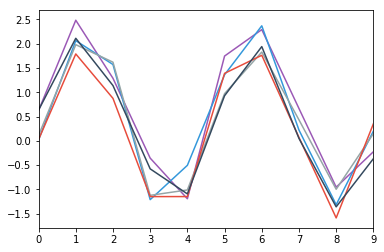

In [5]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  sns.tsplot(create_time_series_normal(1, 10, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

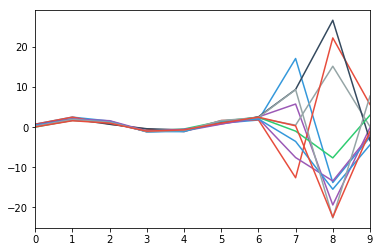

In [6]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 10):
  sns.tsplot(create_time_series_with_anomaly(1, 10, percent_sequence_before_anomaly, percent_sequence_after_anomaly, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

## Create training and evaluation data

In [7]:
number_of_training_normal_sequences = 64000

number_of_validation_normal_1_sequences = 6400
number_of_validation_normal_2_sequences = 6400
number_of_validation_anomalous_sequences = 6400

number_of_test_normal_sequences = 6400
number_of_test_anomalous_sequences = 6400

seq_len = 30
number_of_tags = 5
tag_columns = ["tag_{0}".format(tag) for tag in range(0, number_of_tags)]

In [8]:
tag_data_list = [create_time_series_normal_parameters() 
                 for tag in range(0, number_of_tags)]
tag_data_list

[{'normal_ampl': 1.6516497603672953,
  'normal_freq': 1.8773728386409148,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.4264724991224644,
  'normal_freq': 1.3451706087948256,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.9482804006028966,
  'normal_freq': 1.9841049986774328,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.3346207818499622,
  'normal_freq': 1.4721507016694593,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.642114925918749,
  'normal_freq': 1.127375013177712,
  'normal_noise_noise_scale': 1.0}]

In [9]:
# Create training set using normal sequences
training_normal_sequences_list = [create_time_series_normal(
  number_of_training_normal_sequences, seq_len, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) 
                                  for tag in tag_data_list]
training_normal_sequences_array = np.stack(
  arrays = list(map(
    lambda i: np.stack(
      arrays = list(map(
        lambda j: np.array2string(
          a = training_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), 
        np.arange(0, number_of_training_normal_sequences))), 
      axis = 0), 
    np.arange(0, number_of_tags))), 
  axis = 1)
np.random.shuffle(training_normal_sequences_array)
print("training_normal_sequences_array.shape = \n{}".format(training_normal_sequences_array.shape))

training_normal_sequences_array.shape = 
(64000, 5)


In [10]:
# Create validation sets
# Create set vn1 of normal sequences which will be used for early stopping during training as well as using the error vectors to learn mu and sigma for mahalanobis distance
validation_normal_1_sequences_list = [create_time_series_normal(
  number_of_validation_normal_1_sequences, seq_len, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) 
                                      for tag in tag_data_list]
validation_normal_1_sequences_array = np.stack(
  arrays = list(map(
    lambda i: np.stack(
      arrays = list(map(
        lambda j: np.array2string(
          a = validation_normal_1_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), 
        np.arange(0, number_of_validation_normal_1_sequences))), 
      axis = 0), 
    np.arange(0, number_of_tags))), 
  axis = 1)
print("validation_normal_1_sequences_array.shape = \n{}".format(validation_normal_1_sequences_array.shape))

# Create set vn2 of normal sequences which will be used for tuning the anomaly thresholds
validation_normal_2_sequences_list = [create_time_series_normal(
  number_of_validation_normal_2_sequences, seq_len, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) 
                                      for tag in tag_data_list]
validation_normal_2_sequences_array = np.stack(
  arrays = list(map(lambda i: np.stack(arrays = list(map(
    lambda j: np.array2string(
      a = validation_normal_2_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), 
    np.arange(0, number_of_validation_normal_2_sequences))), 
                                       axis = 0), 
                    np.arange(0, number_of_tags))), 
  axis = 1)
print("validation_normal_2_sequences_array.shape = \n{}".format(validation_normal_2_sequences_array.shape))

# Create set va of anomalous sequences which will be used for tuning the anomaly thresholds
validation_anomalous_sequences_list = [create_time_series_with_anomaly(
  number_of_validation_anomalous_sequences, seq_len, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) 
                                       for tag in tag_data_list]
validation_anomalous_sequences_array = np.stack(
  arrays = list(map(
    lambda i: np.stack(arrays = list(map(
      lambda j: np.array2string(
        a = validation_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), 
      np.arange(0, number_of_validation_anomalous_sequences))), 
                       axis = 0), 
    np.arange(0, number_of_tags))), 
  axis = 1)
print("validation_anomalous_sequences_array.shape = \n{}".format(validation_anomalous_sequences_array.shape))

validation_normal_1_sequences_array.shape = 
(6400, 5)
validation_normal_2_sequences_array.shape = 
(6400, 5)
validation_anomalous_sequences_array.shape = 
(6400, 5)


In [11]:
# Create test sets
# Create set tn of normal sequences which will be used for testing model
test_normal_sequences_list = [create_time_series_normal(
  number_of_test_normal_sequences, seq_len, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) 
                              for tag in tag_data_list]
test_normal_sequences_array = np.stack(
  arrays = list(map(
    lambda i: np.stack(
      arrays = list(map(
        lambda j: np.array2string(
          a = test_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), 
        np.arange(0, number_of_test_normal_sequences))), 
      axis = 0), 
    np.arange(0, number_of_tags))), 
  axis = 1)
print("test_normal_sequences_array.shape = \n{}".format(test_normal_sequences_array.shape))

# Create set ta of anomalous sequences which will be used for testing model
test_anomalous_sequences_list = [create_time_series_with_anomaly(
  number_of_test_anomalous_sequences, seq_len, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) 
                                 for tag in tag_data_list]
test_anomalous_sequences_array = np.stack(
  arrays = list(map(
    lambda i: np.stack(
      arrays = list(map(
        lambda j: np.array2string(
          a = test_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), 
        np.arange(0, number_of_test_anomalous_sequences))), 
      axis = 0), 
    np.arange(0, number_of_tags))), 
  axis = 1)
print("test_anomalous_sequences_array.shape = \n{}".format(test_anomalous_sequences_array.shape))

test_normal_sequences_array.shape = 
(6400, 5)
test_anomalous_sequences_array.shape = 
(6400, 5)


In [12]:
# Combine vn2 and va sets for tuning anomaly thresholds
labeled_validation_normal_2_sequences_array = np.concatenate(
  seq = [validation_normal_2_sequences_array, 
         np.zeros(shape = [validation_normal_2_sequences_array.shape[0], 1], dtype = np.int64)], 
  axis = 1)
labeled_validation_anomalous_sequences_array = np.concatenate(
  seq = [validation_anomalous_sequences_array, 
         np.ones(shape = [validation_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], 
  axis = 1)
labeled_validation_mixed_sequences_array = np.concatenate(
  seq = [labeled_validation_normal_2_sequences_array, 
         labeled_validation_anomalous_sequences_array], 
  axis = 0)
np.random.shuffle(labeled_validation_mixed_sequences_array)
print("labeled_validation_mixed_sequences_array.shape = \n{}".format(labeled_validation_mixed_sequences_array.shape))

# Combine tn and ta sets for testing model
labeled_test_normal_sequences_array = np.concatenate(
  seq = [test_normal_sequences_array, 
         np.zeros(shape = [test_normal_sequences_array.shape[0], 1], dtype = np.int64)], 
  axis = 1)
labled_test_anomalous_sequences_array = np.concatenate(
  seq = [test_anomalous_sequences_array, 
         np.ones(shape = [test_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], 
  axis = 1)
labeled_test_mixed_sequences_array = np.concatenate(
  seq = [labeled_test_normal_sequences_array, 
         labled_test_anomalous_sequences_array], 
  axis = 0)
np.random.shuffle(labeled_test_mixed_sequences_array)
print("labeled_test_mixed_sequences_array.shape = \n{}".format(labeled_test_mixed_sequences_array.shape))

labeled_validation_mixed_sequences_array.shape = 
(12800, 6)
labeled_test_mixed_sequences_array.shape = 
(12800, 6)


In [13]:
np.savetxt(fname = "data/training_normal_sequences.csv", 
           X = training_normal_sequences_array, 
           fmt = '%s', 
           delimiter = ";")

np.savetxt(fname = "data/validation_normal_1_sequences.csv", 
           X = validation_normal_1_sequences_array, 
           fmt = '%s', 
           delimiter = ";")

np.savetxt(fname = "data/labeled_validation_mixed_sequences.csv", 
           X = labeled_validation_mixed_sequences_array, 
           fmt = '%s', 
           delimiter = ";")

np.savetxt(fname = "data/labeled_test_mixed_sequences.csv", 
           X = labeled_test_mixed_sequences_array, 
           fmt = '%s', 
           delimiter = ";")

In [14]:
!head -3 data/training_normal_sequences.csv

5.35341916e-01,1.62427963e+00,-8.48290170e-01,-7.92330818e-01,1.59996964e+00,5.64005220e-01,-9.07497732e-01,1.88866411e+00,1.65763543e+00,-1.27944017e+00,-6.63829108e-02,1.73915404e+00,1.07570263e-03,-7.39967011e-01,1.84565666e+00,9.28276580e-01,-8.74367697e-01,1.27776350e+00,1.49317525e+00,-1.42381813e+00,2.21023277e-01,2.20340863e+00,-7.08605703e-02,-3.27685956e-01,2.21231328e+00,1.17254985e+00,-1.26874553e+00,7.32650805e-01,1.71587898e+00,-1.23273838e+00;5.71968350e-01,1.82454962e+00,1.23135221e+00,-1.79925892e-01,-3.46167663e-01,8.65595492e-01,1.94980511e+00,6.60658713e-01,-6.17245801e-01,3.54957096e-01,1.75640757e+00,1.91006305e+00,-5.87121839e-01,-8.92522845e-01,1.02031589e-03,1.97031076e+00,1.23410796e+00,-1.09194440e+00,-6.62450576e-01,1.47048656e+00,2.28795090e+00,7.59581061e-01,-1.07127455e+00,3.42989503e-01,1.51512834e+00,1.54757652e+00,1.26256070e-01,-1.25381215e+00,6.20069084e-01,1.42975931e+00;0.04041749,2.17130087,-0.82793375,-0.15106699,2.48897918,0.05826132,-0.83910785

In [15]:
!head -3 data/validation_normal_1_sequences.csv

2.48715103e-01,1.62175262e+00,-9.12525495e-01,-5.86126844e-01,2.28422271e+00,8.61252550e-01,-1.16519211e+00,1.39795451e+00,1.31418670e+00,-1.08491479e+00,3.22526432e-01,2.41272800e+00,-5.56473650e-01,-4.85464280e-01,1.66794903e+00,4.85484849e-01,-1.60420171e+00,1.30309719e+00,1.84602707e+00,-1.01641569e+00,1.57240345e-03,2.09407586e+00,-7.36438695e-02,-4.10629450e-01,1.79816238e+00,8.97090503e-01,-6.44621956e-01,1.36032753e+00,1.80122457e+00,-7.70890291e-01;0.23489636,2.33118171,0.9126118,-0.73581593,-0.51859759,0.87806913,1.64429126,0.20297636,-0.53504252,-0.06464885,1.82596899,2.06415412,-0.50503614,-1.09498558,0.17603853,1.94053523,1.5803737,-0.49716577,-1.02599978,1.17905052,1.90411504,0.05301807,-0.81102558,0.1631754,1.16003548,1.37027317,-0.48235681,-0.43521739,0.38226107,1.61213118;0.85629382,1.98722511,-0.95176538,0.2330893,2.33878411,-0.01755494,-0.92500531,2.68099096,0.17424442,-1.53224424,2.26040027,0.94759146,-0.96205877,1.23475587,1.02613023,-1.36271358,1.26221017,1.549318

In [16]:
!head -3 data/labeled_validation_mixed_sequences.csv

0.40886148,2.39504759,-0.55302762,-0.55478917,2.30622592,0.67449508,-0.94157254,1.60540933,1.70671472,-1.50637399,0.82949467,2.40668831,-0.81730588,-0.43564232,2.0841169,0.82949334,-1.42912269,0.92982979,1.37675986,-0.85020253,0.4046131,-15.024334,1.71799593,-11.06375405,-38.91428899,17.30140724,-24.04905217,-20.01671982,17.6639791,-10.40381479;0.46111383,2.29717119,0.99114519,-0.26482821,-0.37153034,0.99728653,1.52786684,0.88508088,-0.71679897,0.19989925,1.87731372,1.80267086,-0.35547713,-0.75250433,0.18574105,1.65548219,1.23272834,-0.13323377,-0.95855019,1.15783445,1.86053493,-7.54780983,12.97943581,-3.35284686,-30.54466942,-24.27887067,-4.33351329,-8.06494212,-5.31672227,-20.6856232;0.38483964,2.36075772,-0.46435472,0.1616821,1.97677941,-0.45743495,-0.47487812,2.2853423,-0.1728357,-1.43431693,2.5373648,1.14680217,-1.16381733,1.46537679,1.2645245,-0.96817583,0.74742504,1.70301806,-1.40351771,0.50367278,2.20136987,-6.99736346,-4.15886965,-28.15191758,-14.92525769,-4.65161111,-27.33138

In [17]:
!head -3 data/labeled_test_mixed_sequences.csv

0.21651224,2.04016484,-0.47583765,-0.23555634,2.45546603,0.3235766,-1.2904606,1.67762694,1.68130188,-0.78770077,0.47435638,1.63288897,-0.1088109,-0.80535951,1.5247533,0.6913622,-1.02549557,1.50642533,1.64192016,-1.29912246,0.42280094,2.57050962,-0.07996142,-0.77842833,1.84379046,1.13805856,-0.82112047,1.65391633,1.95786461,-0.46802792;0.10486821,2.14364583,0.73950086,-0.84900565,-0.4411125,1.17802588,1.71316834,0.94595023,-0.61553838,-0.29301354,1.65156104,1.88037668,-0.52328465,-0.72529186,0.51490249,2.07481068,1.55328056,-0.30451872,-0.6619568,1.14089066,1.48774799,0.59462235,-0.77851109,-0.59419571,1.97041589,1.31435977,-0.05711114,-0.8745225,0.61078849,1.70311224;0.18871692,2.05629687,-0.61333644,-0.62836699,2.22542975,-0.39199273,-1.08371676,1.93101803,0.59474894,-0.71773314,2.23869201,0.36138261,-1.40254869,1.63957311,1.04135741,-1.30427018,1.30502351,1.5772577,-1.11509646,0.82729339,2.10960403,-0.62838693,0.1367821,1.94202738,-0.36754195,-0.30217653,2.36818257,-0.00936663,-1.475

# Local Development

In [18]:
# Set logging to be level of INFO
tf.logging.set_verbosity(tf.logging.INFO)

In [19]:
# Determine CSV and label columns
UNLABELED_CSV_COLUMNS = tag_columns

LABEL_COLUMN = "anomalous_sequence_flag"
LABELED_CSV_COLUMNS = UNLABELED_CSV_COLUMNS + [LABEL_COLUMN]

# Set default values for each CSV column
UNLABELED_DEFAULTS = [[""] for _ in UNLABELED_CSV_COLUMNS]

LABELED_DEFAULTS = UNLABELED_DEFAULTS + [[0.0]]

In [20]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size, params):
  def _input_fn():
    def decode_csv(value_column, seq_len):
      def convert_sequences_from_strings_to_floats(features, column_list):
        def split_and_convert_string(string_tensor):
          # Split string tensor into a sparse tensor based on delimiter
          split_string = tf.string_split(source = tf.expand_dims(
            input = string_tensor, axis = 0), delimiter = ",")

          # Converts the values of the sparse tensor to floats
          converted_tensor = tf.string_to_number(
            string_tensor = split_string.values, 
            out_type = tf.float64)

          # Create a new sparse tensor with the new converted values, 
          # because the original sparse tensor values are immutable
          new_sparse_tensor = tf.SparseTensor(
            indices = split_string.indices, 
            values = converted_tensor, 
            dense_shape = split_string.dense_shape)

          # Create a dense tensor of the float values that were converted from text csv
          dense_floats = tf.sparse_tensor_to_dense(
            sp_input = new_sparse_tensor, default_value = 0.0)

          dense_floats_vector = tf.squeeze(input = dense_floats, axis = 0)

          return dense_floats_vector
          
        for column in column_list:
          features[column] = split_and_convert_string(features[column])
          features[column].set_shape([seq_len])

        return features
        
      if mode == tf.estimator.ModeKeys.TRAIN or (mode == tf.estimator.ModeKeys.EVAL and params["training_mode"] != "tune_anomaly_thresholds"):
        columns = tf.decode_csv(
          records = value_column, 
          record_defaults = UNLABELED_DEFAULTS, 
          field_delim = ";")
        features = dict(zip(UNLABELED_CSV_COLUMNS, columns))
        features = convert_sequences_from_strings_to_floats(
          features, UNLABELED_CSV_COLUMNS)
        return features
      else:
        columns = tf.decode_csv(
          records = value_column, 
          record_defaults = LABELED_DEFAULTS, 
          field_delim = ";")
        features = dict(zip(LABELED_CSV_COLUMNS, columns))
        labels = tf.cast(x = features.pop(LABEL_COLUMN), dtype = tf.float64)
        features = convert_sequences_from_strings_to_floats(
          features, LABELED_CSV_COLUMNS[0:-1])
        return features, labels
    
    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename = filename)

    # Create dataset from file list
    dataset = tf.data.TextLineDataset(filenames = file_list)  # Read text file

    # Decode the CSV file into a features dictionary of tensors
    dataset = dataset.map(map_func = lambda x: decode_csv(x, params["seq_len"]))
    
    # Determine amount of times to repeat file based on if we are training or evaluating
    if mode == tf.estimator.ModeKeys.TRAIN:
      num_epochs = None # indefinitely
    else:
      num_epochs = 1 # end-of-input after this

    # Repeat files num_epoch times
    dataset = dataset.repeat(count = num_epochs)

    # Group the data into batches
    dataset = dataset.batch(batch_size = batch_size)
    
    # Determine if we should shuffle based on if we are training or evaluating
    if mode == tf.estimator.ModeKeys.TRAIN:
      dataset = dataset.shuffle(buffer_size = 10 * batch_size)

    # Create a iterator and then pull the next batch of features from the example queue
    batched_dataset = dataset.make_one_shot_iterator().get_next()

    return batched_dataset
  return _input_fn

In [21]:
def try_out_input_function():
  with tf.Session() as sess:
    fn = read_dataset(
      filename = "data/labeled_validation_mixed_sequences.csv",
      mode = tf.estimator.ModeKeys.EVAL,
      batch_size = 8,
      params = {"seq_len": seq_len,
          "training_mode": "tune_anomaly_thresholds"})

    features = sess.run(fn())
    print("try_out_input_function: features = \n{}".format(features))

#     print("try_out_input_function: features[tag_0].shape = {}".format(features["tag_0"].shape))

In [22]:
# try_out_input_function()

In [23]:
# This function updates the count of records used
def update_count(count_a, count_b):
  return count_a + count_b

# This function updates the mahalanobis distance variables when number_of_rows equals 1
def singleton_batch_cov_variable_updating(
  inner_size, 
  X, 
  count_variable, 
  mean_variable, 
  cov_variable, 
  eps):
  # This function updates the mean vector incrementally
  def update_mean_incremental(count_a, mean_a, value_b):
    mean_ab = (mean_a * tf.cast(x = count_a, dtype = tf.float64) + \
           tf.squeeze(input = value_b, axis = 0)) / tf.cast(x = count_a + 1, dtype = tf.float64)
    return mean_ab

  # This function updates the covariance matrix incrementally
  def update_cov_incremental(count_a, mean_a, cov_a, value_b, mean_ab, sample_cov):
    if sample_cov == True:
      cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + \
            tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) \
        / tf.cast(x = count_a, dtype = tf.float64)
    else:
      cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + \
            tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) \
        / tf.cast(x = count_a + 1, dtype = tf.float64)
    return cov_ab

  # Calculate new combined mean to use for incremental covariance matrix calculation
  mean_ab = update_mean_incremental(
    count_a = count_variable, 
    mean_a = mean_variable, 
    value_b = X) # time_shape = (num_features,), features_shape = (sequence_length,)

  # Update running variables from single example
  count_tensor = update_count(
    count_a = count_variable, 
    count_b = 1) # time_shape = (), features_shape = ()

  mean_tensor = mean_ab # time_shape = (num_features,), features_shape = (sequence_length,)

  if inner_size == 1:
    cov_tensor = tf.zeros_like(
      tensor = cov_variable, dtype = tf.float64)
  else:
    # time_shape = (num_features, num_features)
    # features_shape = (sequence_length, sequence_length)
    cov_tensor = update_cov_incremental(
      count_a = count_variable, 
      mean_a = mean_variable, 
      cov_a = cov_variable, 
      value_b = X, 
      mean_ab = mean_ab, 
      sample_cov = True)

  # Assign values to variables, use control dependencies around return to enforce the mahalanobis 
  # variables to be assigned, the control order matters, hence the separate contexts
  with tf.control_dependencies(
    control_inputs = [tf.assign(
      ref = cov_variable, 
      value = cov_tensor)]):
    with tf.control_dependencies(
      control_inputs = [tf.assign(
        ref = mean_variable, 
        value = mean_tensor)]):
      with tf.control_dependencies(
        control_inputs = [tf.assign(
          ref = count_variable, 
          value = count_tensor)]):
        return tf.identity(input = cov_variable), tf.identity(input = mean_variable), tf.identity(input = count_variable)

# This function updates the mahalanobis distance variables when number_of_rows does NOT equal 1
def non_singleton_batch_cov_variable_updating(
  cur_batch_size, 
  inner_size, 
  X, 
  count_variable, 
  mean_variable, 
  cov_variable, 
  eps):
  # This function updates the mean vector using a batch of data
  def update_mean_batch(count_a, mean_a, count_b, mean_b):
    mean_ab = (mean_a * tf.cast(x = count_a, dtype = tf.float64) + \
               mean_b * tf.cast(x = count_b, dtype = tf.float64)) \
               / tf.cast(x = count_a + count_b, dtype = tf.float64)
    return mean_ab

  # This function updates the covariance matrix using a batch of data
  def update_cov_batch(count_a, mean_a, cov_a, count_b, mean_b, cov_b, sample_cov):
    mean_diff = tf.expand_dims(input = mean_a - mean_b, axis = 0)

    if sample_cov == True:
      cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + \
                cov_b * tf.cast(x = count_b - 1, dtype = tf.float64) + \
                tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * \
                tf.cast(x = count_a * count_b, dtype = tf.float64) \
                / tf.cast(x = count_a + count_b, dtype = tf.float64)) \
                / tf.cast(x = count_a + count_b - 1, dtype = tf.float64)
    else:
      cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + \
                cov_b * tf.cast(x = count_b, dtype = tf.float64) + \
                tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * \
                tf.cast(x = count_a * count_b, dtype = tf.float64) \
                / tf.cast(x = count_a + count_b, dtype = tf.float64)) \
                / tf.cast(x = count_a + count_b, dtype = tf.float64)
    return cov_ab          

  # Find statistics of batch
  number_of_rows = cur_batch_size * inner_size

  # time_shape = (num_features,), features_shape = (sequence_length,)
  X_mean = tf.reduce_mean(input_tensor = X, axis = 0)

  # time_shape = (cur_batch_size * sequence_length, num_features)
  # features_shape = (cur_batch_size * num_features, sequence_length)
  X_centered = X - X_mean

  if inner_size > 1:
    # time_shape = (num_features, num_features)
    # features_shape = (sequence_length, sequence_length)
    X_cov = tf.matmul(
      a = X_centered,
      b = X_centered, 
      transpose_a = True) / tf.cast(x = number_of_rows - 1, dtype = tf.float64)

  # Update running variables from batch statistics
  count_tensor = update_count(
    count_a = count_variable, 
    count_b = number_of_rows) # time_shape = (), features_shape = ()

  mean_tensor = update_mean_batch(
    count_a = count_variable, 
    mean_a = mean_variable, 
    count_b = number_of_rows, 
    mean_b = X_mean) # time_shape = (num_features,), features_shape = (sequence_length,)

  if inner_size == 1:
    cov_tensor = tf.zeros_like(
      tensor = cov_variable, dtype = tf.float64)
  else:
    # time_shape = (num_features, num_features)
    # features_shape = (sequence_length, sequence_length)
    cov_tensor = update_cov_batch(
      count_a = count_variable, 
      mean_a = mean_variable, 
      cov_a = cov_variable, 
      count_b = number_of_rows, 
      mean_b = X_mean, 
      cov_b = X_cov, 
      sample_cov = True)

  # Assign values to variables, use control dependencies around return to enforce the mahalanobis 
  # variables to be assigned, the control order matters, hence the separate contexts
  with tf.control_dependencies(
    control_inputs = [tf.assign(ref = cov_variable, value = cov_tensor)]):
    with tf.control_dependencies(
      control_inputs = [tf.assign(ref = mean_variable, value = mean_tensor)]):
      with tf.control_dependencies(
        control_inputs = [tf.assign(ref = count_variable, value = count_tensor)]):
        return tf.identity(input = cov_variable), tf.identity(input = mean_variable), tf.identity(input = count_variable)

In [24]:
def mahalanobis_distance(error_vectors_reshaped, mean_vector, inv_covariance, final_shape):
  # time_shape = (current_batch_size * seq_len, num_features)
  # features_shape = (current_batch_size * num_features, seq_len)
  error_vectors_reshaped_centered = error_vectors_reshaped - mean_vector

  # time_shape = (num_features, current_batch_size * seq_len)
  # features_shape = (seq_len, current_batch_size * num_features)
  mahalanobis_right_product = tf.matmul(
    a = inv_covariance,
    b = error_vectors_reshaped_centered,
    transpose_b = True)

  # time_shape = (current_batch_size * seq_len, current_batch_size * seq_len)
  # features_shape = (current_batch_size * num_features, current_batch_size * num_features)
  mahalanobis_distance_vectorized = tf.matmul(
    a = error_vectors_reshaped_centered,
    b = mahalanobis_right_product)

  # time_shape = (current_batch_size * seq_len,)
  # features_shape = (current_batch_size * num_features,)
  mahalanobis_distance_flat = tf.diag_part(input = mahalanobis_distance_vectorized)

  # time_shape = (current_batch_size, seq_len)
  # features_shape = (current_batch_size, num_features)
  mahalanobis_distance_final_shaped = tf.reshape(
    tensor = mahalanobis_distance_flat, 
    shape = [-1, final_shape])

  # time_shape = (current_batch_size, seq_len)
  # features_shape = (current_batch_size, num_features)
  mahalanobis_distance_final_shaped_abs = tf.abs(x = mahalanobis_distance_final_shaped)

  return mahalanobis_distance_final_shaped_abs

In [25]:
def update_anomaly_threshold_variables(
  labels_normal_mask, 
  labels_anomalous_mask, 
  num_thresholds, 
  anomaly_thresholds, 
  mahalanobis_distance, 
  tp_at_thresholds_variable, 
  fn_at_thresholds_variable, 
  fp_at_thresholds_variable, 
  tn_at_thresholds_variable,
  mode):
  
  if mode == tf.estimator.ModeKeys.TRAIN:
    # time_shape = (num_time_anomaly_thresholds, current_batch_size, sequence_length)
    # features_shape = (num_features_anomaly_thresholds, current_batch_size, number_of_features)
    mahalanobis_distance_over_thresholds = tf.map_fn(
      fn = lambda anomaly_threshold: mahalanobis_distance > anomaly_threshold, 
      elems = anomaly_thresholds, 
      dtype = tf.bool)
  else:
    # time_shape = (current_batch_size, sequence_length)
    # features_shape = (current_batch_size, number_of_features)
    mahalanobis_distance_over_thresholds = mahalanobis_distance > anomaly_thresholds

  # time_shape = (num_time_anomaly_thresholds, current_batch_size)
  # features_shape = (num_features_anomaly_thresholds, current_batch_size)    
  mahalanobis_distance_any_over_thresholds = tf.reduce_any(
    input_tensor = mahalanobis_distance_over_thresholds, 
    axis = -1)
    
  if mode == tf.estimator.ModeKeys.EVAL:
    # time_shape = (1, current_batch_size)
    # features_shape = (1, current_batch_size)
    mahalanobis_distance_any_over_thresholds = tf.expand_dims(
      input = mahalanobis_distance_any_over_thresholds, axis = 0)

  # time_shape = (num_time_anomaly_thresholds, current_batch_size)
  # features_shape = (num_features_anomaly_thresholds, current_batch_size)
  predicted_normals = tf.equal(
    x = mahalanobis_distance_any_over_thresholds, 
    y = False)

  # time_shape = (num_time_anomaly_thresholds, current_batch_size)
  # features_shape = (num_features_anomaly_thresholds, current_batch_size)
  predicted_anomalies = tf.equal(
    x = mahalanobis_distance_any_over_thresholds, 
    y = True)
  
  # Calculate confusion matrix of current batch
  # time_shape = (num_time_anomaly_thresholds,)
  # features_shape = (num_features_anomaly_thresholds,)
  tp = tf.reduce_sum(
    input_tensor = tf.cast(
      x = tf.map_fn(
        fn = lambda threshold: tf.logical_and(
          x = labels_anomalous_mask, 
          y = predicted_anomalies[threshold, :]), 
        elems = tf.range(start = 0, limit = num_thresholds, dtype = tf.int64), 
        dtype = tf.bool), 
      dtype = tf.int64), 
    axis = 1)

  fn = tf.reduce_sum(
    input_tensor = tf.cast(
      x = tf.map_fn(
        fn = lambda threshold: tf.logical_and(
          x = labels_anomalous_mask, 
          y = predicted_normals[threshold, :]), 
        elems = tf.range(start = 0, limit = num_thresholds, dtype = tf.int64), 
        dtype = tf.bool), 
      dtype = tf.int64), 
    axis = 1)

  fp = tf.reduce_sum(
    input_tensor = tf.cast(
      x = tf.map_fn(
        fn = lambda threshold: tf.logical_and(
          x = labels_normal_mask, 
          y = predicted_anomalies[threshold, :]), 
        elems = tf.range(start = 0, limit = num_thresholds, dtype = tf.int64), 
        dtype = tf.bool), 
      dtype = tf.int64), 
    axis = 1)

  tn = tf.reduce_sum(
    input_tensor = tf.cast(
      x = tf.map_fn(
        fn = lambda threshold: tf.logical_and(
          x = labels_normal_mask, 
          y = predicted_normals[threshold, :]), 
        elems = tf.range(start = 0, limit = num_thresholds, dtype = tf.int64), 
        dtype = tf.bool), 
      dtype = tf.int64), 
    axis = 1)
  
  if mode == tf.estimator.ModeKeys.EVAL:
    # shape = ()
    tp = tf.squeeze(input = tp)
    fn = tf.squeeze(input = fn)
    fp = tf.squeeze(input = fp)
    tn = tf.squeeze(input = tn)

  with tf.control_dependencies(
    control_inputs = [tf.assign_add(ref = tp_at_thresholds_variable, value = tp), 
                      tf.assign_add(ref = fn_at_thresholds_variable, value = fn), 
                      tf.assign_add(ref = fp_at_thresholds_variable, value = fp), 
                      tf.assign_add(ref = tn_at_thresholds_variable, value = tn)]):
    return tf.identity(input = tp_at_thresholds_variable), tf.identity(input = fn_at_thresholds_variable), tf.identity(input = fp_at_thresholds_variable), tf.identity(input = tn_at_thresholds_variable)

In [26]:
def calculate_composite_classification_metrics(anomaly_thresholds, tp, fn, fp, tn, f_score_beta):
  # time_shape = (num_time_anomaly_thresholds,)
  # features_shape = (num_features_anomaly_thresholds,)
  acc = tf.cast(x = tp + tn, dtype = tf.float64) \
    / tf.cast(x = tp + fn + fp + tn, dtype = tf.float64)
  pre = tf.cast(x = tp, dtype = tf.float64) / tf.cast(x = tp + fp, dtype = tf.float64)
  rec = tf.cast(x = tp, dtype = tf.float64) / tf.cast(x = tp + fn, dtype = tf.float64)
  f_beta_score = (1.0 + f_score_beta ** 2) * (pre * rec) / (f_score_beta ** 2 * pre + rec)

  return acc, pre, rec, f_beta_score

In [27]:
def find_best_anomaly_threshold(
  anomaly_thresholds, f_beta_score, user_passed_anomaly_threshold, anomaly_threshold_variable):
  if user_passed_anomaly_threshold == None:
    best_anomaly_threshold = tf.gather(
      params = anomaly_thresholds, 
      indices = tf.argmax(input = f_beta_score, 
      axis = 0)) # shape = ()
  else:
    best_anomaly_threshold = user_passed_anomaly_threshold # shape = ()

  with tf.control_dependencies(
    control_inputs = [
      tf.assign(ref = anomaly_threshold_variable, value = best_anomaly_threshold)]):
    return tf.identity(input = anomaly_threshold_variable)

In [28]:
# Create our model function to be used in our custom estimator
def pca_anomaly_detection(features, labels, mode, params):
  print("\npca_anomaly_detection: features = \n{}".format(features))
  print("pca_anomaly_detection: labels = \n{}".format(labels))
  print("pca_anomaly_detection: mode = \n{}".format(mode))
  print("pca_anomaly_detection: params = \n{}".format(params))

  # 0. Get input sequence tensor into correct shape
  # Get dynamic batch size in case there was a partially filled batch
  cur_batch_size = tf.shape(
    input = features[UNLABELED_CSV_COLUMNS[0]], out_type = tf.int64)[0]

  # Get the number of features 
  num_features = len(UNLABELED_CSV_COLUMNS)

  # Stack all of the features into a 3-D tensor
  X = tf.stack(
    values = [features[key] for key in UNLABELED_CSV_COLUMNS], 
    axis = 2) # shape = (cur_batch_size, seq_len, num_features)

  # Reshape into a 2-D tensors
  # Time based
  # shape = (cur_batch_size * seq_len, num_features)
  X_time = tf.reshape(
    tensor = X, 
    shape = [cur_batch_size * params["seq_len"], num_features])
  
  # Features based
  # shape = (cur_batch_size, num_features, seq_len)
  X_transposed = tf.transpose(a = X, perm = [0, 2, 1])
  # shape = (cur_batch_size * num_features, seq_len)
  X_features = tf.reshape(
    tensor = X_transposed, 
    shape = [cur_batch_size * num_features, params["seq_len"]])

  ################################################################################
  
  # Variables for calculating error distribution statistics
  with tf.variable_scope(name_or_scope = "pca_variables", reuse = tf.AUTO_REUSE):
    # Time based
    pca_time_count_variable = tf.get_variable(
      name = "pca_time_count_variable", # shape = ()
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False)

    pca_time_mean_variable = tf.get_variable(
      name = "pca_time_mean_variable", # shape = (num_features,)
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features],  dtype = tf.float64),
      trainable = False)

    pca_time_cov_variable = tf.get_variable(
      name = "pca_time_cov_variable", # shape = (num_features, num_features)
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features, num_features], dtype = tf.float64),
      trainable = False)

    pca_time_eigenvalues_variable = tf.get_variable(
      name = "pca_time_eigenvalues_variable", # shape = (num_features,)
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features], dtype = tf.float64),
      trainable = False)

    pca_time_eigenvectors_variable = tf.get_variable(
      name = "pca_time_eigenvectors_variable", # shape = (num_features, num_features)
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features, num_features], dtype = tf.float64),
      trainable = False)

    # Features based
    pca_features_count_variable = tf.get_variable(
      name = "pca_features_count_variable", # shape = ()
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False)

    pca_features_mean_variable = tf.get_variable(
      name = "pca_features_mean_variable", # shape = (seq_len,)
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"]], dtype = tf.float64),
      trainable = False)

    pca_features_cov_variable = tf.get_variable(
      name = "pca_features_cov_variable", # shape = (seq_len, seq_len)
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"], params["seq_len"]], dtype = tf.float64),
      trainable = False)

    pca_features_eigenvalues_variable = tf.get_variable(
      name = "pca_features_eigenvalues_variable", # shape = (seq_len,)
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"]], dtype = tf.float64),
      trainable = False)

    pca_features_eigenvectors_variable = tf.get_variable(
      name = "pca_features_eigenvectors_variable", # shape = (seq_len, seq_len)
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"], params["seq_len"]], dtype = tf.float64),
      trainable = False)
  
  # Variables for calculating error distribution statistics
  with tf.variable_scope(
    name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
    # Time based
    abs_err_count_time_variable = tf.get_variable(
      name = "abs_err_count_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    abs_err_mean_time_variable = tf.get_variable(
      name = "abs_err_mean_time_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features], dtype = tf.float64),
      trainable = False) # shape = (num_features,)

    abs_err_cov_time_variable = tf.get_variable(
      name = "abs_err_cov_time_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features, num_features], dtype = tf.float64),
      trainable = False) # shape = (num_features, num_features)

    abs_err_inv_cov_time_variable = tf.get_variable(
      name = "abs_err_inv_cov_time_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features, num_features], dtype = tf.float64),
      trainable = False) # shape = (num_features, num_features)

    # Features based
    abs_err_count_features_variable = tf.get_variable(
      name = "abs_err_count_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    abs_err_mean_features_variable = tf.get_variable(
      name = "abs_err_mean_features_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"]], dtype = tf.float64),
      trainable = False) # shape = (seq_len,)

    abs_err_cov_features_variable = tf.get_variable(
      name = "abs_err_cov_features_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"], params["seq_len"]], dtype = tf.float64),
      trainable = False) # shape = (seq_len, seq_len)

    abs_err_inv_cov_features_variable = tf.get_variable(
      name = "abs_err_inv_cov_features_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"], params["seq_len"]], dtype = tf.float64),
      trainable = False) # shape = (seq_len, seq_len)
  
  # Variables for automatically tuning anomaly thresholds
  with tf.variable_scope(
    name_or_scope = "mahalanobis_distance_threshold_variables", reuse = tf.AUTO_REUSE):
    # Time based
    tp_at_thresholds_time_variable = tf.get_variable(
      name = "tp_at_thresholds_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_time_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_time_anomaly_thresholds,)

    fn_at_thresholds_time_variable = tf.get_variable(
      name = "fn_at_thresholds_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_time_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_time_anomaly_thresholds,)

    fp_at_thresholds_time_variable = tf.get_variable(
      name = "fp_at_thresholds_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_time_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_time_anomaly_thresholds,)

    tn_at_thresholds_time_variable = tf.get_variable(
      name = "tn_at_thresholds_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_time_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_time_anomaly_thresholds,)

    time_anomaly_threshold_variable = tf.get_variable(
      name = "time_anomaly_threshold_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [], dtype = tf.float64),
      trainable = False) # shape = ()

    # Features based
    tp_at_thresholds_features_variable = tf.get_variable(
      name = "tp_at_thresholds_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_features_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_features_anomaly_thresholds,)

    fn_at_thresholds_features_variable = tf.get_variable(
      name = "fn_at_thresholds_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_features_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_features_anomaly_thresholds,)

    fp_at_thresholds_features_variable = tf.get_variable(
      name = "fp_at_thresholds_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_features_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_features_anomaly_thresholds,)

    tn_at_thresholds_features_variable = tf.get_variable(
      name = "tn_at_thresholds_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_features_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_features_anomaly_thresholds,)

    features_anomaly_threshold_variable = tf.get_variable(
      name = "features_anomaly_threshold_variable", # shape = ()
      dtype = tf.float64,
      initializer = tf.zeros(shape = [], dtype = tf.float64),
      trainable = False)

  # Variables for automatically tuning anomaly thresholds
  with tf.variable_scope(
    name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
    # Time based
    tp_at_threshold_eval_time_variable = tf.get_variable(
      name = "tp_at_threshold_eval_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    fn_at_threshold_eval_time_variable = tf.get_variable(
      name = "fn_at_threshold_eval_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    fp_at_threshold_eval_time_variable = tf.get_variable(
      name = "fp_at_threshold_eval_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    tn_at_threshold_eval_time_variable = tf.get_variable(
      name = "tn_at_threshold_eval_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    # Features based
    tp_at_threshold_eval_features_variable = tf.get_variable(
      name = "tp_at_threshold_eval_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    fn_at_threshold_eval_features_variable = tf.get_variable(
      name = "fn_at_threshold_eval_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    fp_at_threshold_eval_features_variable = tf.get_variable(
      name = "fp_at_threshold_eval_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    tn_at_threshold_eval_features_variable = tf.get_variable(
      name = "tn_at_threshold_eval_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

  dummy_variable = tf.get_variable(
    name = "dummy_variable",
    dtype = tf.float64,
    initializer = tf.zeros(shape = [], dtype = tf.float64),
    trainable = True) # shape = ()
  
  # Now branch off based on which mode we are in
  predictions_dict = None
  loss = None
  train_op = None
  eval_metric_ops = None
  export_outputs = None
  
  # 3. Loss function, training/eval ops
  if mode == tf.estimator.ModeKeys.TRAIN and params["training_mode"] == "reconstruction":
    with tf.variable_scope(name_or_scope = "pca_variables", reuse = tf.AUTO_REUSE):
      # Check if batch is a singleton or not, very important for covariance math

      # Time based ########################################
      singleton_condition = tf.equal(
        x = cur_batch_size * params["seq_len"], y = 1) # shape = ()

      pca_time_cov_variable, pca_time_mean_variable, pca_time_count_variable = tf.cond(
        pred = singleton_condition, 
        true_fn = lambda: singleton_batch_cov_variable_updating(
          params["seq_len"], 
          X_time, 
          pca_time_count_variable, 
          pca_time_mean_variable, 
          pca_time_cov_variable,
          params["eps"]), 
        false_fn = lambda: non_singleton_batch_cov_variable_updating(
          cur_batch_size, 
          params["seq_len"], 
          X_time, 
          pca_time_count_variable, 
          pca_time_mean_variable, 
          pca_time_cov_variable,
          params["eps"]))

      pca_time_eigenvalues_tensor, pca_time_eigenvectors_tensor = tf.linalg.eigh(
        tensor = pca_time_cov_variable) # shape = (num_features,) & (num_features, num_features)

      # Features based ########################################
      singleton_features_condition = tf.equal(
        x = cur_batch_size * num_features, y = 1) # shape = ()

      pca_features_cov_variable, pca_features_mean_variable, pca_features_count_variable = tf.cond(
        pred = singleton_features_condition, 
        true_fn = lambda: singleton_batch_cov_variable_updating(
          num_features, 
          X_features, 
          pca_features_count_variable, pca_features_mean_variable, 
          pca_features_cov_variable,
          params["eps"]), 
        false_fn = lambda: non_singleton_batch_cov_variable_updating(
          cur_batch_size, 
          num_features, 
          X_features, 
          pca_features_count_variable, 
          pca_features_mean_variable, 
          pca_features_cov_variable,
          params["eps"]))

      pca_features_eigenvalues_tensor, pca_features_eigenvectors_tensor = tf.linalg.eigh(
        tensor = pca_features_cov_variable) # shape = (seq_len,) & (seq_len, seq_len)

    # Lastly use control dependencies around loss to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
    with tf.control_dependencies(
      control_inputs = [pca_time_cov_variable, pca_features_cov_variable]):
      with tf.control_dependencies(
        control_inputs = [pca_time_mean_variable, pca_features_mean_variable]):
        with tf.control_dependencies(
          control_inputs = [pca_time_count_variable, pca_features_count_variable]):
          with tf.control_dependencies(
            control_inputs = [tf.assign(ref = pca_time_eigenvalues_variable, value = pca_time_eigenvalues_tensor), 
                              tf.assign(ref = pca_time_eigenvectors_variable, value = pca_time_eigenvectors_tensor),
                              tf.assign(ref = pca_features_eigenvalues_variable, value = pca_features_eigenvalues_tensor), 
                              tf.assign(ref = pca_features_eigenvectors_variable, value = pca_features_eigenvectors_tensor)]):
            loss = tf.reduce_sum(input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

            train_op = tf.contrib.layers.optimize_loss(
              loss = loss,
              global_step = tf.train.get_global_step(),
              learning_rate = params["learning_rate"],
              optimizer = "SGD")
  else:
    # Time based
    # shape = (cur_batch_size * seq_len, num_features)
    X_time_centered = X_time - pca_time_mean_variable
    # shape = (cur_batch_size * seq_len, params["k_principal_components"])
    X_time_projected = tf.matmul(
      a = X_time_centered, 
      b = pca_time_eigenvectors_variable[:, -params["k_principal_components"]:])
    # shape = (cur_batch_size * seq_len, num_features)
    X_time_reconstructed = tf.matmul(
      a = X_time_projected, 
      b = pca_time_eigenvectors_variable[:, -params["k_principal_components"]:], 
      transpose_b = True)
    # shape = (cur_batch_size * seq_len, num_features)
    X_time_abs_reconstruction_error = tf.abs(
      x = X_time_centered - X_time_reconstructed)

    # Features based
    # shape = (cur_batch_size * num_features, seq_len)
    X_features_centered = X_features - pca_features_mean_variable
    # shape = (cur_batch_size * num_features, params["k_principal_components"])
    X_features_projected = tf.matmul(
      a = X_features_centered, 
      b = pca_features_eigenvectors_variable[:, -params["k_principal_components"]:])
    # shape = (cur_batch_size * num_features, seq_len)
    X_features_reconstructed = tf.matmul(
      a = X_features_projected, 
      b = pca_features_eigenvectors_variable[:, -params["k_principal_components"]:], 
      transpose_b = True)
    # shape = (cur_batch_size * num_features, seq_len)
    X_features_abs_reconstruction_error = tf.abs(
      x = X_features_centered - X_features_reconstructed)

    if mode == tf.estimator.ModeKeys.TRAIN and params["training_mode"] == "calculate_error_distribution_statistics":
      ################################################################################

      with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
        # Time based ########################################
        singleton_time_condition = tf.equal(
          x = cur_batch_size * params["seq_len"], y = 1) # shape = ()
        
        cov_time_variable, mean_time_variable, count_time_variable = tf.cond(
          pred = singleton_time_condition, 
          true_fn = lambda: singleton_batch_cov_variable_updating(
            params["seq_len"], 
            X_time_abs_reconstruction_error, 
            abs_err_count_time_variable, 
            abs_err_mean_time_variable, 
            abs_err_cov_time_variable,
            params["eps"]), 
          false_fn = lambda: non_singleton_batch_cov_variable_updating(
            cur_batch_size, 
            params["seq_len"], 
            X_time_abs_reconstruction_error, 
            abs_err_count_time_variable, 
            abs_err_mean_time_variable, 
            abs_err_cov_time_variable,
            params["eps"]))

        # Features based ########################################
        singleton_features_condition = tf.equal(
          x = cur_batch_size * num_features, y = 1) # shape = ()
        
        cov_features_variable, mean_features_variable, count_features_variable = tf.cond(
          pred = singleton_features_condition, 
          true_fn = lambda: singleton_batch_cov_variable_updating(
            num_features, 
            X_features_abs_reconstruction_error, 
            abs_err_count_features_variable, 
            abs_err_mean_features_variable, 
            abs_err_cov_features_variable,
            params["eps"]), 
          false_fn = lambda: non_singleton_batch_cov_variable_updating(
            cur_batch_size, 
            num_features, 
            X_features_abs_reconstruction_error, 
            abs_err_count_features_variable, 
            abs_err_mean_features_variable, 
            abs_err_cov_features_variable,
            params["eps"]))

      # Lastly use control dependencies around loss to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
      with tf.control_dependencies(
        control_inputs = [cov_time_variable, cov_features_variable]):
        with tf.control_dependencies(
          control_inputs = [mean_time_variable, mean_features_variable]):
          with tf.control_dependencies(
            control_inputs = [count_time_variable, count_features_variable]):
            # Time based
            # shape = (num_features, num_features)
            abs_err_inv_cov_time_tensor = \
              tf.matrix_inverse(input = cov_time_variable + \
                tf.eye(num_rows = tf.shape(input = cov_time_variable)[0], 
                     dtype = tf.float64) * params["eps"])
            # Features based
            # shape = (seq_len, seq_len)
            abs_err_inv_cov_features_tensor = \
              tf.matrix_inverse(input = cov_features_variable + \
                tf.eye(num_rows = tf.shape(input = cov_features_variable)[0], 
                     dtype = tf.float64) * params["eps"])
            
            with tf.control_dependencies(
              control_inputs = [tf.assign(ref = abs_err_inv_cov_time_variable, value = abs_err_inv_cov_time_tensor), 
                                tf.assign(ref = abs_err_inv_cov_features_variable, value = abs_err_inv_cov_features_tensor)]):
              loss = tf.reduce_sum(input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

              train_op = tf.contrib.layers.optimize_loss(
                loss = loss,
                global_step = tf.train.get_global_step(),
                learning_rate = params["learning_rate"],
                optimizer = "SGD")
    elif mode == tf.estimator.ModeKeys.EVAL and params["training_mode"] != "tune_anomaly_thresholds":
      # Reconstruction loss on evaluation set
      loss = tf.losses.mean_squared_error(labels = X_time_centered, predictions = X_time_abs_reconstruction_error)

      if params["training_mode"] == "reconstruction":
        # Reconstruction eval metrics
        eval_metric_ops = {
          "rmse": tf.metrics.root_mean_squared_error(labels = X_time_centered, predictions = X_time_abs_reconstruction_error),
          "mae": tf.metrics.mean_absolute_error(labels = X_time_centered, predictions = X_time_abs_reconstruction_error)
        }
    elif mode == tf.estimator.ModeKeys.PREDICT or ((mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL) and params["training_mode"] == "tune_anomaly_thresholds"):
      with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
        # Time based
        mahalanobis_distance_time = mahalanobis_distance(
          error_vectors_reshaped = X_time_abs_reconstruction_error,
          mean_vector = abs_err_mean_time_variable, 
          inv_covariance = abs_err_inv_cov_time_variable, 
          final_shape = params["seq_len"]) # shape = (cur_batch_size, seq_len)
        
        # Features based
        mahalanobis_distance_features = mahalanobis_distance(
          error_vectors_reshaped = X_features_abs_reconstruction_error,
          mean_vector = abs_err_mean_features_variable, 
          inv_covariance = abs_err_inv_cov_features_variable,
          final_shape = num_features) # shape = (cur_batch_size, num_features)

      if mode != tf.estimator.ModeKeys.PREDICT:
        labels_normal_mask = tf.equal(x = labels, y = 0)
        labels_anomalous_mask = tf.equal(x = labels, y = 1)

        if mode == tf.estimator.ModeKeys.TRAIN:
          with tf.variable_scope(
            name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
            # Time based
            # shape = (num_time_anomaly_thresholds,)
            time_anomaly_thresholds = tf.linspace(
              start = tf.constant(value = params["min_time_anomaly_threshold"], dtype = tf.float64),
              stop = tf.constant(value = params["max_time_anomaly_threshold"], dtype = tf.float64), 
              num = params["num_time_anomaly_thresholds"])

            tp_time_update_op, fn_time_update_op, fp_time_update_op, tn_time_update_op = \
              update_anomaly_threshold_variables(
                labels_normal_mask, 
                labels_anomalous_mask, 
                params["num_time_anomaly_thresholds"], 
                time_anomaly_thresholds, 
                mahalanobis_distance_time, 
                tp_at_thresholds_time_variable, 
                fn_at_thresholds_time_variable, 
                fp_at_thresholds_time_variable, 
                tn_at_thresholds_time_variable,
                mode)

            # Features based
            # shape = (num_features_anomaly_thresholds,)
            features_anomaly_thresholds = tf.linspace(
              start = tf.constant(value = params["min_features_anomaly_threshold"], dtype = tf.float64),
              stop = tf.constant(value = params["max_features_anomaly_threshold"], dtype = tf.float64), 
              num = params["num_features_anomaly_thresholds"])

            tp_features_update_op, fn_features_update_op, fp_features_update_op, tn_features_update_op = \
              update_anomaly_threshold_variables(
                labels_normal_mask, 
                labels_anomalous_mask, 
                params["num_features_anomaly_thresholds"], 
                features_anomaly_thresholds, 
                mahalanobis_distance_features, 
                tp_at_thresholds_features_variable, 
                fn_at_thresholds_features_variable, 
                fp_at_thresholds_features_variable, 
                tn_at_thresholds_features_variable, 
                mode)

          # Reconstruction loss on evaluation set
          with tf.control_dependencies(
            control_inputs = [
              tp_time_update_op, 
              fn_time_update_op, 
              fp_time_update_op, 
              tn_time_update_op, 
              tp_features_update_op, 
              fn_features_update_op, 
              fp_features_update_op, 
              tn_features_update_op]):
            # Time based
            acc_time, pre_time, rec_time, f_beta_score_time = \
              calculate_composite_classification_metrics(
                time_anomaly_thresholds, 
                tp_at_thresholds_time_variable, 
                fn_at_thresholds_time_variable, 
                fp_at_thresholds_time_variable, 
                tn_at_thresholds_time_variable,
                params["f_score_beta"])

            # Features based
            acc_features, pre_features, rec_features, f_beta_score_features = \
              calculate_composite_classification_metrics(
                features_anomaly_thresholds, 
                tp_at_thresholds_features_variable, 
                fn_at_thresholds_features_variable, 
                fp_at_thresholds_features_variable, 
                tn_at_thresholds_features_variable,
                params["f_score_beta"])

            with tf.control_dependencies(
              control_inputs = [pre_time, pre_features]):
              with tf.control_dependencies(
                control_inputs = [rec_time, rec_features]):
                with tf.control_dependencies(
                  control_inputs = [f_beta_score_time, f_beta_score_features]):
                  # Time based
                  best_anomaly_threshold_time = find_best_anomaly_threshold(
                    time_anomaly_thresholds, 
                    f_beta_score_time, 
                    params["time_anomaly_threshold"], 
                    time_anomaly_threshold_variable)

                  # Features based
                  best_anomaly_threshold_features = find_best_anomaly_threshold(
                    features_anomaly_thresholds, 
                    f_beta_score_features, 
                    params["features_anomaly_threshold"], 
                    features_anomaly_threshold_variable)

                  with tf.control_dependencies(
                    control_inputs = [
                      tf.assign(
                        ref = time_anomaly_threshold_variable, 
                        value = best_anomaly_threshold_time), 
                      tf.assign(ref = 
                                features_anomaly_threshold_variable, 
                                value = best_anomaly_threshold_features)]):

                    loss = tf.reduce_sum(
                      input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

                    train_op = tf.contrib.layers.optimize_loss(
                      loss = loss,
                      global_step = tf.train.get_global_step(),
                      learning_rate = params["learning_rate"],
                      optimizer = "SGD")
        elif mode == tf.estimator.ModeKeys.EVAL:
          with tf.variable_scope(
            name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
            # Time based
            tp_time_update_op, fn_time_update_op, fp_time_update_op, tn_time_update_op = \
              update_anomaly_threshold_variables(
                labels_normal_mask, 
                labels_anomalous_mask, 
                1,
                time_anomaly_threshold_variable, 
                mahalanobis_distance_time, 
                tp_at_threshold_eval_time_variable, 
                fn_at_threshold_eval_time_variable, 
                fp_at_threshold_eval_time_variable, 
                tn_at_threshold_eval_time_variable,
                mode)

            # Features based
            tp_features_update_op, fn_features_update_op, fp_features_update_op, tn_features_update_op = \
              update_anomaly_threshold_variables(
                labels_normal_mask, 
                labels_anomalous_mask, 
                1,
                features_anomaly_threshold_variable, 
                mahalanobis_distance_features, 
                tp_at_threshold_eval_features_variable, 
                fn_at_threshold_eval_features_variable, 
                fp_at_threshold_eval_features_variable, 
                tn_at_threshold_eval_features_variable,
                mode)

          with tf.variable_scope(
            name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
            # Time based
            acc_time_update_op, pre_time_update_op, rec_time_update_op, f_beta_score_time_update_op = \
              calculate_composite_classification_metrics(
                time_anomaly_threshold_variable, 
                tp_at_threshold_eval_time_variable, 
                fn_at_threshold_eval_time_variable, 
                fp_at_threshold_eval_time_variable, 
                tn_at_threshold_eval_time_variable,
                params["f_score_beta"]) 

            # Features based
            acc_features_update_op, pre_features_update_op, rec_features_update_op, f_beta_score_features_update_op = \
              calculate_composite_classification_metrics(
                features_anomaly_threshold_variable, 
                tp_at_threshold_eval_features_variable, 
                fn_at_threshold_eval_features_variable, 
                fp_at_threshold_eval_features_variable, 
                tn_at_threshold_eval_features_variable,
                params["f_score_beta"]) 

          loss = tf.losses.mean_squared_error(labels = X_time_centered, predictions = X_time_reconstructed)

          acc_at_threshold_eval_time_variable = tf.cast(x = tp_at_threshold_eval_time_variable + tn_at_threshold_eval_time_variable, dtype = tf.float64) \
            / tf.cast(x = tp_at_threshold_eval_time_variable + fn_at_threshold_eval_time_variable + fp_at_threshold_eval_time_variable + tn_at_threshold_eval_time_variable, dtype = tf.float64)
          pre_at_threshold_eval_time_variable = tf.cast(x = tp_at_threshold_eval_time_variable, dtype = tf.float64) \
            / tf.cast(x = tp_at_threshold_eval_time_variable + fp_at_threshold_eval_time_variable, dtype = tf.float64)
          rec_at_threshold_eval_time_variable = tf.cast(x = tp_at_threshold_eval_time_variable, dtype = tf.float64) \
            / tf.cast(x = tp_at_threshold_eval_time_variable + fn_at_threshold_eval_time_variable, dtype = tf.float64)
          f_beta_score_at_threshold_eval_time_variable = (1.0 + params["f_score_beta"] ** 2) * pre_at_threshold_eval_time_variable * rec_at_threshold_eval_time_variable \
            / (params["f_score_beta"] ** 2 * pre_at_threshold_eval_time_variable + rec_at_threshold_eval_time_variable)

          acc_at_threshold_eval_features_variable = tf.cast(x = tp_at_threshold_eval_features_variable + tn_at_threshold_eval_features_variable, dtype = tf.float64) \
            / tf.cast(x = tp_at_threshold_eval_features_variable + fn_at_threshold_eval_features_variable + fp_at_threshold_eval_features_variable + tn_at_threshold_eval_features_variable, dtype = tf.float64)
          pre_at_threshold_eval_features_variable = tf.cast(x = tp_at_threshold_eval_features_variable, dtype = tf.float64) \
            / tf.cast(x = tp_at_threshold_eval_features_variable + fp_at_threshold_eval_features_variable, dtype = tf.float64)
          rec_at_threshold_eval_features_variable = tf.cast(x = tp_at_threshold_eval_features_variable, dtype = tf.float64) \
            / tf.cast(x = tp_at_threshold_eval_features_variable + fn_at_threshold_eval_features_variable, dtype = tf.float64)
          f_beta_score_at_threshold_eval_features_variable = (1.0 + params["f_score_beta"] ** 2) * pre_at_threshold_eval_features_variable * rec_at_threshold_eval_features_variable \
            / (params["f_score_beta"] ** 2 * pre_at_threshold_eval_features_variable + rec_at_threshold_eval_features_variable)

          # Anomaly detection eval metrics
          eval_metric_ops = {
            # Time based
            "time_anomaly_tp": (tp_at_threshold_eval_time_variable, tp_time_update_op),
            "time_anomaly_fn": (fn_at_threshold_eval_time_variable, fn_time_update_op),
            "time_anomaly_fp": (fp_at_threshold_eval_time_variable, fp_time_update_op),
            "time_anomaly_tn": (tn_at_threshold_eval_time_variable, tn_time_update_op),

            "time_anomaly_acc": (acc_at_threshold_eval_time_variable, acc_time_update_op),
            "time_anomaly_pre": (pre_at_threshold_eval_time_variable, pre_time_update_op),
            "time_anomaly_rec": (rec_at_threshold_eval_time_variable, rec_time_update_op),
            "time_anomaly_f_beta_score": (f_beta_score_at_threshold_eval_time_variable, f_beta_score_time_update_op),

             # Features based
            "features_anomaly_tp": (tp_at_threshold_eval_features_variable, tp_features_update_op),
            "features_anomaly_fn": (fn_at_threshold_eval_features_variable, fn_features_update_op),
            "features_anomaly_fp": (fp_at_threshold_eval_features_variable, fp_features_update_op),
            "features_anomaly_tn": (tn_at_threshold_eval_features_variable, tn_features_update_op),

            "features_anomaly_acc": (acc_at_threshold_eval_features_variable, acc_features_update_op),
            "features_anomaly_pre": (pre_at_threshold_eval_features_variable, pre_features_update_op),
            "features_anomaly_rec": (rec_at_threshold_eval_features_variable, rec_features_update_op),
            "features_anomaly_f_beta_score": (f_beta_score_at_threshold_eval_features_variable, f_beta_score_features_update_op)
          }
      else: # mode == tf.estimator.ModeKeys.PREDICT
        # Flag predictions as either normal or anomalous
        time_anomaly_flags = tf.where(
          condition = tf.reduce_any(
            input_tensor = tf.greater(
              x = tf.abs(x = mahalanobis_distance_time),
              y = time_anomaly_threshold_variable), 
            axis = 1), 
          x = tf.ones(shape = [cur_batch_size], dtype = tf.int64), 
          y = tf.zeros(shape = [cur_batch_size], dtype = tf.int64)) # shape = (cur_batch_size,)

        features_anomaly_flags = tf.where(
          condition = tf.reduce_any(
            input_tensor = tf.greater(
              x = tf.abs(x = mahalanobis_distance_features),
              y = features_anomaly_threshold_variable), 
            axis = 1), 
          x = tf.ones(shape = [cur_batch_size], dtype = tf.int64), 
          y = tf.zeros(shape = [cur_batch_size], dtype = tf.int64)) # shape = (cur_batch_size,)

        # Create predictions dictionary
        predictions_dict = {
          "X_time_abs_reconstruction_error": tf.reshape(
            tensor = X_time_abs_reconstruction_error, 
            shape = [cur_batch_size, params["seq_len"], num_features]), 
          "X_features_abs_reconstruction_error": tf.transpose(
            a = tf.reshape(
              tensor = X_features_abs_reconstruction_error, 
              shape = [cur_batch_size, num_features, params["seq_len"]]), 
            perm = [0, 2, 1]),
          "mahalanobis_distance_time": mahalanobis_distance_time, 
          "mahalanobis_distance_features": mahalanobis_distance_features, 
          "time_anomaly_flags": time_anomaly_flags, 
          "features_anomaly_flags": features_anomaly_flags}

        # Create export outputs
        export_outputs = {
          "predict_export_outputs": tf.estimator.export.PredictOutput(
            outputs = predictions_dict)}

  # Return EstimatorSpec
  return tf.estimator.EstimatorSpec(
    mode = mode,
    predictions = predictions_dict,
    loss = loss,
    train_op = train_op,
    eval_metric_ops = eval_metric_ops,
    export_outputs = export_outputs)

In [29]:
# Create our serving input function to accept the data at serving and send it in the 
# right format to our custom estimator
def serving_input_fn(seq_len):
    # This function fixes the shape and type of our input strings
    def fix_shape_and_type_for_serving(placeholder):
        current_batch_size = tf.shape(input = placeholder, out_type = tf.int64)[0]
        
        # String split each string in batch and output values from the resulting SparseTensors
        split_string = tf.stack(values = tf.map_fn( # shape = (batch_size, seq_len)
            fn = lambda x: tf.string_split(source = [placeholder[x]], delimiter = ',').values, 
            elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int64), 
            dtype = tf.string), axis = 0)
        
        # Convert each string in the split tensor to float
        # shape = (batch_size, seq_len)
        feature_tensor = tf.string_to_number(string_tensor = split_string, out_type = tf.float64)
        
        return feature_tensor
    
    # This function fixes dynamic shape ambiguity of last dimension so that we will be able to 
    # use it in our DNN (since tf.layers.dense require the last dimension to be known)
    def get_shape_and_set_modified_shape_2D(tensor, additional_dimension_sizes):
        # Get static shape for tensor and convert it to list
        shape = tensor.get_shape().as_list()
        # Set outer shape to additional_dimension_sizes[0] since know this is the correct size
        shape[1] = additional_dimension_sizes[0]
        # Set the shape of tensor to our modified shape
        tensor.set_shape(shape = shape) # shape = (batch_size, additional_dimension_sizes[0])

        return tensor
            
    # Create placeholders to accept the data sent to the model at serving time
    # All features come in as a batch of strings, shape = (batch_size,), 
    # this was so because of passing the arrays to online ml-engine prediction
    feature_placeholders = {
        feature: tf.placeholder(
          dtype = tf.string, shape = [None]) for feature in UNLABELED_CSV_COLUMNS
    }
    
    # Create feature tensors
    features = {key: fix_shape_and_type_for_serving(placeholder = tensor) 
      for key, tensor in feature_placeholders.items()}
    
    # Fix dynamic shape ambiguity of feature tensors for our DNN
    features = {key: get_shape_and_set_modified_shape_2D(
      tensor = tensor, additional_dimension_sizes = [seq_len]) for key, tensor in features.items()}

    return tf.estimator.export.ServingInputReceiver(
      features = features, receiver_tensors = feature_placeholders)

In [30]:
# Create estimator to train and evaluate
def train_and_evaluate(args):
  # Create our custom estimator using our model function
  estimator = tf.estimator.Estimator(
    model_fn = pca_anomaly_detection,
    model_dir = args["output_dir"],
    params = {
      "seq_len": args["seq_len"],
      "learning_rate": args["learning_rate"],
      "training_mode": args["training_mode"],
      "k_principal_components": args["k_principal_components"],
      "num_time_anomaly_thresholds": args["num_time_anomaly_thresholds"],
      "num_features_anomaly_thresholds": args["num_features_anomaly_thresholds"],
      "min_time_anomaly_threshold": args["min_time_anomaly_threshold"],
      "max_time_anomaly_threshold": args["max_time_anomaly_threshold"],
      "min_features_anomaly_threshold": args["min_features_anomaly_threshold"],
      "max_features_anomaly_threshold": args["max_features_anomaly_threshold"],
      "time_anomaly_threshold": args["time_anomaly_threshold"], 
      "features_anomaly_threshold": args["features_anomaly_threshold"],
      "eps": args["eps"],
      "f_score_beta": args["f_score_beta"]})
  
  if args["training_mode"] == "reconstruction":
    estimator.train(
      input_fn = read_dataset(
        filename = args["train_file_pattern"], 
        mode = tf.estimator.ModeKeys.EVAL, 
        batch_size = args["train_batch_size"],
        params = args),
      steps = None)
  else:
    if args["training_mode"] == "calculate_error_distribution_statistics":
      # Get final mahalanobis statistics over the entire validation_1 dataset
      estimator.train(
        input_fn = read_dataset(
          filename = args["train_file_pattern"], 
          mode = tf.estimator.ModeKeys.EVAL, 
          batch_size = args["train_batch_size"],
          params = args),
        steps = None)

    elif args["training_mode"] == "tune_anomaly_thresholds":
      # Tune anomaly thresholds using valdiation_2 and validation_anomaly datasets
      estimator.train(
        input_fn = read_dataset(
          filename = args["train_file_pattern"], 
          mode = tf.estimator.ModeKeys.EVAL, 
          batch_size = args["train_batch_size"],
          params = args),
        steps = None)
      
      estimator.evaluate(
        input_fn = read_dataset(
          filename = args["eval_file_pattern"], 
          mode = tf.estimator.ModeKeys.EVAL, 
          batch_size = args["eval_batch_size"],
          params = args),
        steps = None)

    # Export savedmodel with learned error distribution statistics to be used for inference
    estimator.export_savedmodel(
      export_dir_base = args['output_dir'] + "/export/exporter", 
      serving_input_receiver_fn = lambda: serving_input_fn(args["seq_len"]))
    
  return estimator

In [31]:
arguments = {}
# File arguments
arguments["train_file_pattern"] = "data/training_normal_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["output_dir"] = "trained_model"

# Sequence shape hyperparameters
arguments["seq_len"] = seq_len

# Training parameters
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["train_steps"] = 2000
arguments["learning_rate"] = 0.01
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Anomaly detection
arguments["training_mode"] = "reconstruction"
arguments["k_principal_components"] = min(number_of_tags, 3)
arguments["num_time_anomaly_thresholds"] = 300
arguments["num_features_anomaly_thresholds"] = 300
arguments["min_time_anomaly_threshold"] = 1
arguments["max_time_anomaly_threshold"] = 100
arguments["min_features_anomaly_threshold"] = 1
arguments["max_features_anomaly_threshold"] = 100
arguments["time_anomaly_threshold"] = None
arguments["features_anomaly_threshold"] = None
arguments["eps"] = 10**-12
arguments["f_score_beta"] = 0.05

## Train reconstruction variables

In [32]:
# Train the model
shutil.rmtree(path = arguments["output_dir"], ignore_errors = True) # start fresh each time
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_device_fn': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efb36cceda0>, '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_model_dir': 'trained_model', '_service': None, '_log_step_count_steps': 100, '_train_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_is_chief': True, '_keep_checkpoint_max': 5, '_experimental_distribute': None, '_protocol': None, '_task_type': 'worker', '_eval_distribute': None, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_task_id': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_master': ''}
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'

## Look at PCA variable values

In [33]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'anomaly_threshold_eval_variables/fn_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/fn_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/fp_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/fp_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/tn_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/tn_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/tp_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/tp_at_threshold_eval_time_variable',
 'dummy_variable',
 'global_step',
 'mahalanobis_distance_threshold_variables/features_anomaly_threshold_variable',
 'mahalanobis_distance_threshold_variables/fn_at_thresholds_features_variable',
 'mahalanobis_distance_threshold_variables/fn_at_thresholds_time_variable',
 'mahalanobis_distance_threshold_variables/fp_at_thresholds_features_variable',
 'mahalanobis_distance_th

In [34]:
arr_training_normal_sequences = np.genfromtxt(fname = "data/training_normal_sequences.csv", delimiter = ';', dtype = str)
print("arr_training_normal_sequences.shape = {}".format(arr_training_normal_sequences.shape))
if number_of_tags == 1:
  arr_training_normal_sequences = np.expand_dims(a = arr_training_normal_sequences, axis = -1)
  
arr_training_normal_sequences_features = np.stack(
  arrays = [np.stack(
    arrays = [np.array(arr_training_normal_sequences[example_index, tag_index].split(',')).astype(np.float) 
              for tag_index in range(number_of_tags)], axis = 1) 
            for example_index in range(len(arr_training_normal_sequences))], axis = 0)

print("arr_training_normal_sequences_features.shape = {}".format(arr_training_normal_sequences_features.shape))

arr_training_normal_sequences.shape = (64000, 5)
arr_training_normal_sequences_features.shape = (64000, 30, 5)


### Time based

In [35]:
X_time = arr_training_normal_sequences_features.reshape(arr_training_normal_sequences_features.shape[0] * arr_training_normal_sequences_features.shape[1], number_of_tags)
X_time.shape

(1920000, 5)

#### Count

In [36]:
estimator.get_variable_value(name = "pca_variables/pca_time_count_variable")

1920000

In [37]:
time_count = X_time.shape[0]
time_count

1920000

#### Mean

In [38]:
estimator.get_variable_value(name = "pca_variables/pca_time_mean_variable")

array([0.50664394, 0.54495522, 0.53680924, 0.49614661, 0.55690725])

In [39]:
time_mean = np.mean(X_time, axis = 0)
time_mean

array([0.50664394, 0.54495522, 0.53680924, 0.49614661, 0.55690725])

In [40]:
estimator.get_variable_value(name = "pca_variables/pca_time_mean_variable") / time_mean

array([1., 1., 1., 1., 1.])

#### Covariance

In [41]:
if estimator.get_variable_value(name = "pca_variables/pca_time_cov_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "pca_variables/pca_time_cov_variable"))
else:
  print(estimator.get_variable_value(name = "pca_variables/pca_time_cov_variable").shape)

[[ 1.44188229 -0.01370197 -0.02521143 -0.03415416 -0.02290388]
 [-0.01370197  1.09438171  0.01517352 -0.15795746  0.03609734]
 [-0.02521143  0.01517352  1.9724199   0.02706946  0.02331364]
 [-0.03415416 -0.15795746  0.02706946  0.97274093 -0.09024727]
 [-0.02290388  0.03609734  0.02331364 -0.09024727  1.41801289]]


In [42]:
if arguments["seq_len"] == 1:
  time_cov = np.zeros(shape = [number_of_tags, number_of_tags])
else:
  time_cov = np.cov(np.transpose(X_time))
if time_cov.shape[0] <= 10:
  print(time_cov)
else:
  print(time_cov.shape)

[[ 1.44188229 -0.01370197 -0.02521143 -0.03415416 -0.02290388]
 [-0.01370197  1.09438171  0.01517352 -0.15795746  0.03609734]
 [-0.02521143  0.01517352  1.9724199   0.02706946  0.02331364]
 [-0.03415416 -0.15795746  0.02706946  0.97274093 -0.09024727]
 [-0.02290388  0.03609734  0.02331364 -0.09024727  1.41801289]]


In [43]:
estimator.get_variable_value(name = "pca_variables/pca_time_cov_variable") / time_cov

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

#### Eigenvalues

In [44]:
if estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable"))
else:
  print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable").shape)

[0.85552299 1.17608319 1.43092125 1.46139796 1.97551233]


In [45]:
time_eigenvalues, time_eigenvectors = np.linalg.eigh(a = time_cov)
if time_eigenvalues.shape[0] <= 10:
  print(time_eigenvalues)
else:
  print(time_eigenvalues.shape)

[0.85552299 1.17608319 1.43092125 1.46139796 1.97551233]


In [46]:
estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable") / time_eigenvalues

array([1., 1., 1., 1., 1.])

#### Eigenvectors

In [47]:
if estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable"))
else:
  print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable").shape)

[[-0.06389873 -0.04638795  0.76318494  0.63932772  0.05073392]
 [-0.54031815  0.8153906   0.13620877 -0.15619737 -0.01562119]
 [ 0.02821099  0.00860242  0.01719566  0.06207252 -0.99748757]
 [-0.83225322 -0.48744957 -0.21945062  0.14520043 -0.02248908]
 [-0.10262541 -0.30871547  0.59206558 -0.73615643 -0.04116842]]


In [48]:
if time_eigenvectors.shape[0] <= 10:
  print(time_eigenvectors)
else:
  print(time_eigenvectors.shape)

[[ 0.06389873 -0.04638795 -0.76318494 -0.63932772 -0.05073392]
 [ 0.54031815  0.8153906  -0.13620877  0.15619737  0.01562119]
 [-0.02821099  0.00860242 -0.01719566 -0.06207252  0.99748757]
 [ 0.83225322 -0.48744957  0.21945062 -0.14520043  0.02248908]
 [ 0.10262541 -0.30871547 -0.59206558  0.73615643  0.04116842]]


In [49]:
estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable") / time_eigenvectors

array([[-1.,  1., -1., -1., -1.],
       [-1.,  1., -1., -1., -1.],
       [-1.,  1., -1., -1., -1.],
       [-1.,  1., -1., -1., -1.],
       [-1.,  1., -1., -1., -1.]])

### Features based

In [50]:
X_features = np.transpose(arr_training_normal_sequences_features, [0, 2, 1]).reshape(arr_training_normal_sequences_features.shape[0] * number_of_tags, arr_training_normal_sequences_features.shape[1])
X_features.shape

(320000, 30)

#### Count

In [51]:
estimator.get_variable_value(name = "pca_variables/pca_features_count_variable")

320000

In [52]:
feat_count = X_features.shape[0]
feat_count

320000

#### Mean

In [53]:
estimator.get_variable_value(name = "pca_variables/pca_features_mean_variable")

array([ 0.49935604,  2.01166538,  0.45469415, -0.38327619,  0.55052912,
        0.48671055,  0.5216933 ,  1.18132885,  0.3085865 , -0.30804352,
        0.92890342,  0.9328693 , -0.1444289 ,  0.60236495,  1.22005154,
        0.09577629, -0.0745283 ,  0.79832385,  0.73188849,  0.57791221,
        0.66680406,  0.0930424 ,  0.06379693,  0.9253186 ,  0.94510452,
        0.37235905,  0.29688001,  0.25781034,  0.36079969,  0.87448088])

In [54]:
feat_mean = np.mean(X_features, axis = 0)
feat_mean

array([ 0.49935604,  2.01166538,  0.45469415, -0.38327619,  0.55052912,
        0.48671055,  0.5216933 ,  1.18132885,  0.3085865 , -0.30804352,
        0.92890342,  0.9328693 , -0.1444289 ,  0.60236495,  1.22005154,
        0.09577629, -0.0745283 ,  0.79832385,  0.73188849,  0.57791221,
        0.66680406,  0.0930424 ,  0.06379693,  0.9253186 ,  0.94510452,
        0.37235905,  0.29688001,  0.25781034,  0.36079969,  0.87448088])

In [55]:
estimator.get_variable_value(name = "pca_variables/pca_features_mean_variable") / feat_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Covariance

In [56]:
if estimator.get_variable_value(name = "pca_variables/pca_features_cov_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "pca_variables/pca_features_cov_variable"))
else:
  print(estimator.get_variable_value(name = "pca_variables/pca_features_cov_variable").shape)

(30, 30)


In [57]:
if number_of_tags == 1:
  feat_cov = np.zeros(shape = [arguments["seq_len"], arguments["seq_len"]])
else:
  feat_cov = np.cov(np.transpose(X_features))
if feat_cov.shape[0] <= 10:
  print(feat_cov)
else:
  print(feat_cov.shape)

(30, 30)


In [58]:
estimator.get_variable_value(name = "pca_variables/pca_features_cov_variable") / feat_cov

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

#### Eigenvalues

In [59]:
if estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable"))
else:
  print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable").shape)

(30,)


In [60]:
feat_eigenvalues, feat_eigenvectors = np.linalg.eigh(a = feat_cov)
if feat_eigenvalues.shape[0] <= 10:
  print(feat_eigenvalues)
else:
  print(feat_eigenvalues.shape)

(30,)


In [61]:
estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable") / feat_eigenvalues

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Eigenvectors

In [62]:
if estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable"))
else:
  print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable").shape)

(30, 30)


In [63]:
if feat_eigenvectors.shape[0] <= 10:
  print(feat_eigenvectors)
else:
  print(feat_eigenvectors.shape)

(30, 30)


In [64]:
estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable") / feat_eigenvectors

array([[-1.        ,  1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  1.        ,  1.        , -1.        ,
         1.        ,  1.        ,  1.        , -1.        , -1.        ,
         1.        , -1.        ,  1.        , -1.        ,  1.        ,
        -1.        ,  1.        , -1.        ,  1.        ,  1.        ,
         1.        , -1.        , -1.        , -1.        , -1.        ],
       [-1.        ,  1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  1.        ,  1.        , -1.        ,
         1.        ,  1.        ,  1.        , -1.        , -1.        ,
         1.        , -1.        ,  1.        , -1.        ,  1.        ,
        -1.        ,  1.        , -1.        ,  1.        ,  1.        ,
         1.        , -1.        , -1.        , -1.        , -1.        ],
       [-1.        ,  1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  1.        ,  1

## Train error distribution statistics variables

In [65]:
arguments["training_mode"] = "calculate_error_distribution_statistics"
arguments["train_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_device_fn': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efaac0ae9b0>, '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_model_dir': 'trained_model', '_service': None, '_log_step_count_steps': 100, '_train_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_is_chief': True, '_keep_checkpoint_max': 5, '_experimental_distribute': None, '_protocol': None, '_task_type': 'worker', '_eval_distribute': None, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_task_id': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_master': ''}
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_2': <tf.Tensor 'IteratorGetNext:2' shape=(?, 30) dtype=float64>, 'ta

## Look at variable values

In [66]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'anomaly_threshold_eval_variables/fn_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/fn_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/fp_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/fp_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/tn_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/tn_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/tp_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/tp_at_threshold_eval_time_variable',
 'dummy_variable',
 'global_step',
 'mahalanobis_distance_threshold_variables/features_anomaly_threshold_variable',
 'mahalanobis_distance_threshold_variables/fn_at_thresholds_features_variable',
 'mahalanobis_distance_threshold_variables/fn_at_thresholds_time_variable',
 'mahalanobis_distance_threshold_variables/fp_at_thresholds_features_variable',
 'mahalanobis_distance_th

In [67]:
arr_validation_normal_1_sequences = np.genfromtxt(fname = "data/validation_normal_1_sequences.csv", delimiter = ';', dtype = str)
print("arr_validation_normal_1_sequences.shape = {}".format(arr_validation_normal_1_sequences.shape))
if number_of_tags == 1:
  arr_validation_normal_1_sequences = np.expand_dims(a = arr_validation_normal_1_sequences, axis = -1)
  
arr_validation_normal_1_sequences_features = np.stack(
  arrays = [np.stack(
    arrays = [np.array(arr_validation_normal_1_sequences[example_index, tag_index].split(',')).astype(np.float) 
              for tag_index in range(number_of_tags)], axis = 1) 
            for example_index in range(len(arr_validation_normal_1_sequences))], axis = 0)

dict_validation_normal_1_sequences_features = {tag: arr_validation_normal_1_sequences_features[:, :, index] for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}

validation_normal_1_predictions_list = [prediction for prediction in estimator.predict(
  input_fn = tf.estimator.inputs.numpy_input_fn(
    x = dict_validation_normal_1_sequences_features,
    y = None,
    batch_size = 32,
    num_epochs = 1,
    shuffle = False,
    queue_capacity = 1000))]

arr_validation_normal_1_sequences.shape = (6400, 5)
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>}
pca_anomaly_detection: labels = 
None
pca_anomaly_detection: mode = 
infer
pca_anomaly_detection: params = 
{'time_anomaly_threshold': None, 'training_mode': 'calculate_error_distribution_statistics', 'max_features_anomaly_threshold': 100, 'num_features_anomaly_thresholds': 300, 'min_features_anomaly_threshold': 1, 'features

### Time based

In [68]:
validation_normal_1_time_absolute_error = np.stack(arrays = [prediction["X_time_abs_reconstruction_error"] for prediction in validation_normal_1_predictions_list], axis = 0)
time_abs_err = validation_normal_1_time_absolute_error.reshape(validation_normal_1_time_absolute_error.shape[0] * validation_normal_1_time_absolute_error.shape[1], number_of_tags)
time_abs_err.shape

(192000, 5)

#### Count

In [69]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_count_time_variable")

192000

In [70]:
time_count = time_abs_err.shape[0]
time_count

192000

#### Mean

In [71]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_mean_time_variable")

array([0.06557202, 0.87948723, 0.0229426 , 0.78854519, 0.2768234 ])

In [72]:
time_mean = np.mean(time_abs_err, axis = 0)
time_mean

array([0.06557202, 0.87948723, 0.0229426 , 0.78854519, 0.2768234 ])

In [73]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_mean_time_variable") / time_mean

array([1., 1., 1., 1., 1.])

#### Covariance

In [74]:
if estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_cov_time_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_cov_time_variable"))
else:
  print(estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_cov_time_variable").shape)

[[1.71439271e-03 4.05046771e-03 5.17809520e-04 2.02817328e-02
  5.32124653e-03]
 [4.05046771e-03 2.54474453e-01 1.10764331e-03 4.24197055e-02
  4.52634374e-02]
 [5.17809520e-04 1.10764331e-03 2.40792497e-04 6.96405572e-03
  3.76192364e-04]
 [2.02817328e-02 4.24197055e-02 6.96405572e-03 2.49010451e-01
  4.95000452e-02]
 [5.32124653e-03 4.52634374e-02 3.76192364e-04 4.95000452e-02
  4.40680257e-02]]


In [75]:
if arguments["seq_len"] == 1:
  time_cov = np.zeros(shape = [number_of_tags, number_of_tags])
else:
  time_cov = np.cov(np.transpose(time_abs_err))
if time_cov.shape[0] <= 10:
  print(time_cov)
else:
  print(time_cov.shape)

[[1.71439271e-03 4.05046771e-03 5.17809520e-04 2.02817328e-02
  5.32124653e-03]
 [4.05046771e-03 2.54474453e-01 1.10764331e-03 4.24197055e-02
  4.52634374e-02]
 [5.17809520e-04 1.10764331e-03 2.40792497e-04 6.96405572e-03
  3.76192364e-04]
 [2.02817328e-02 4.24197055e-02 6.96405572e-03 2.49010451e-01
  4.95000452e-02]
 [5.32124653e-03 4.52634374e-02 3.76192364e-04 4.95000452e-02
  4.40680257e-02]]


In [76]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_cov_time_variable") / time_cov

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

#### Inverse Covariance

In [77]:
if estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inv_cov_time_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inv_cov_time_variable"))
else:
  print(estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inv_cov_time_variable").shape)

[[ 1.71468013e+05  1.03974676e+02  1.13545281e+05 -1.65176304e+04
  -3.22731131e+03]
 [ 1.03974676e+02  6.92922894e+00 -3.54085884e+02  4.58770755e+00
  -2.18027223e+01]
 [ 1.13545281e+05 -3.54085884e+02  1.62462584e+05 -1.39080849e+04
   8.88588939e+02]
 [-1.65176304e+04  4.58770755e+00 -1.39080849e+04  1.69741906e+03
   2.01881590e+02]
 [-3.22731131e+03 -2.18027223e+01  8.88588939e+02  2.01881590e+02
   2.00434599e+02]]


In [78]:
time_inv = np.linalg.inv(time_cov + np.eye(number_of_tags) * arguments["eps"])
if time_inv.shape[0] <= 10:
  print(time_inv)
else:
  print(time_inv.shape)

[[ 1.71468013e+05  1.03974676e+02  1.13545281e+05 -1.65176304e+04
  -3.22731131e+03]
 [ 1.03974676e+02  6.92922894e+00 -3.54085884e+02  4.58770755e+00
  -2.18027223e+01]
 [ 1.13545281e+05 -3.54085884e+02  1.62462584e+05 -1.39080849e+04
   8.88588939e+02]
 [-1.65176304e+04  4.58770755e+00 -1.39080849e+04  1.69741906e+03
   2.01881590e+02]
 [-3.22731131e+03 -2.18027223e+01  8.88588939e+02  2.01881590e+02
   2.00434599e+02]]


In [79]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inv_cov_time_variable") / time_inv

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

### Features based

In [80]:
validation_normal_1_features_absolute_error = np.stack(arrays = [prediction["X_features_abs_reconstruction_error"] for prediction in validation_normal_1_predictions_list], axis = 0)
feat_abs_err = np.transpose(validation_normal_1_features_absolute_error, [0, 2, 1]).reshape(validation_normal_1_features_absolute_error.shape[0] * number_of_tags, validation_normal_1_features_absolute_error.shape[1])
feat_abs_err.shape

(32000, 30)

#### Count

In [81]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_count_features_variable")

32000

In [82]:
feat_count = feat_abs_err.shape[0]
feat_count

32000

#### Mean

In [83]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_mean_features_variable")

array([0.24855595, 0.26121778, 0.32661644, 0.30739142, 0.54737642,
       0.67289242, 0.74500947, 0.8956757 , 0.80387002, 0.73728652,
       0.66764267, 0.31066487, 0.37962873, 0.33992847, 0.23983729,
       0.6330119 , 0.29614973, 0.61549722, 0.27484392, 0.38516784,
       0.21949609, 0.22861103, 0.3637894 , 0.22503854, 0.52629259,
       0.23439781, 0.49782341, 0.27122575, 0.32952454, 0.28178431])

In [84]:
feat_mean = np.mean(feat_abs_err, axis = 0)
feat_mean

array([0.24855595, 0.26121778, 0.32661644, 0.30739142, 0.54737642,
       0.67289242, 0.74500947, 0.8956757 , 0.80387002, 0.73728652,
       0.66764267, 0.31066487, 0.37962873, 0.33992847, 0.23983729,
       0.6330119 , 0.29614973, 0.61549722, 0.27484392, 0.38516784,
       0.21949609, 0.22861103, 0.3637894 , 0.22503854, 0.52629259,
       0.23439781, 0.49782341, 0.27122575, 0.32952454, 0.28178431])

In [85]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_mean_features_variable") / feat_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Covariance

In [86]:
if estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_cov_features_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_cov_features_variable"))
else:
  print(estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_cov_features_variable").shape)

(30, 30)


In [87]:
if number_of_tags == 1:
  feat_cov = np.zeros(shape = [arguments["seq_len"], arguments["seq_len"]])
else:
  feat_cov = np.cov(np.transpose(feat_abs_err))
if feat_cov.shape[0] <= 10:
  print(feat_cov)
else:
  print(feat_cov.shape)

(30, 30)


In [88]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_cov_features_variable") / feat_cov

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

#### Inverse Covariance

In [89]:
if estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inv_cov_features_variable").shape[0] <= 10:
  print(estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inv_cov_features_variable"))
else:
  print(estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inv_cov_features_variable").shape)

(30, 30)


In [90]:
feat_inv = np.linalg.inv(feat_cov + np.eye(arguments["seq_len"]) * arguments["eps"])
if feat_inv.shape[0] <= 10:
  print(feat_inv)
else:
  print(feat_inv.shape)

(30, 30)


In [91]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inv_cov_features_variable") / feat_inv

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

## Tune anomaly thresholds

In [92]:
arguments["training_mode"] = "tune_anomaly_thresholds"
arguments["train_file_pattern"] = "data/labeled_validation_mixed_sequences.csv"
arguments["eval_file_pattern"] = "data/labeled_validation_mixed_sequences.csv"
arguments["train_batch_size"] = 64
arguments["eval_batch_size"] = 64
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_device_fn': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ef771a4f6a0>, '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_model_dir': 'trained_model', '_service': None, '_log_step_count_steps': 100, '_train_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_is_chief': True, '_keep_checkpoint_max': 5, '_experimental_distribute': None, '_protocol': None, '_task_type': 'worker', '_eval_distribute': None, '_num_ps_replicas': 0, '_save_summary_steps': 100, '_task_id': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_master': ''}
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_2': <tf.Tensor 'IteratorGetNext:2' shape=(?, 30) dtype=float64>, 'ta

#### Time based

In [93]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/tp_at_thresholds_time_variable")

array([6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 64

In [94]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/fn_at_thresholds_time_variable")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/fp_at_thresholds_time_variable")

array([6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6397, 6395, 6392, 6390, 6379,
       6363, 6345, 6320, 6281, 6235, 6197, 6117, 6041, 5938, 5851, 5754,
       5651, 5542, 5462, 5386, 5305, 5244, 5186, 5114, 5043, 4986, 4908,
       4854, 4784, 4711, 4642, 4566, 4487, 4431, 4379, 4300, 4238, 4183,
       4126, 4059, 4000, 3935, 3875, 3818, 3767, 3705, 3653, 3602, 3535,
       3463, 3398, 3347, 3295, 3254, 3206, 3152, 3097, 3061, 3007, 2956,
       2909, 2873, 2821, 2752, 2694, 2638, 2593, 2547, 2507, 2468, 2413,
       2366, 2324, 2274, 2236, 2190, 2157, 2117, 2072, 2040, 2002, 1961,
       1917, 1884, 1849, 1830, 1797, 1757, 1718, 1676, 1650, 1620, 1593,
       1564, 1541, 1511, 1487, 1451, 1420, 1393, 1364, 1339, 1307, 1283,
       1257, 1236, 1207, 1188, 1166, 1138, 1119, 1102, 1077, 1059, 1047,
       1023, 1000,  984,  966,  946,  921,  905,  884,  868,  855,  837,
        822,  812,  797,  779,  769,  754,  742,  7

In [96]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/tn_at_thresholds_time_variable")

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    3,    5,    8,   10,   21,
         37,   55,   80,  119,  165,  203,  283,  359,  462,  549,  646,
        749,  858,  938, 1014, 1095, 1156, 1214, 1286, 1357, 1414, 1492,
       1546, 1616, 1689, 1758, 1834, 1913, 1969, 2021, 2100, 2162, 2217,
       2274, 2341, 2400, 2465, 2525, 2582, 2633, 2695, 2747, 2798, 2865,
       2937, 3002, 3053, 3105, 3146, 3194, 3248, 3303, 3339, 3393, 3444,
       3491, 3527, 3579, 3648, 3706, 3762, 3807, 3853, 3893, 3932, 3987,
       4034, 4076, 4126, 4164, 4210, 4243, 4283, 4328, 4360, 4398, 4439,
       4483, 4516, 4551, 4570, 4603, 4643, 4682, 4724, 4750, 4780, 4807,
       4836, 4859, 4889, 4913, 4949, 4980, 5007, 5036, 5061, 5093, 5117,
       5143, 5164, 5193, 5212, 5234, 5262, 5281, 5298, 5323, 5341, 5353,
       5377, 5400, 5416, 5434, 5454, 5479, 5495, 5516, 5532, 5545, 5563,
       5578, 5588, 5603, 5621, 5631, 5646, 5658, 56

In [97]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/time_anomaly_threshold_variable")

99.66889632107024

#### Features based

In [98]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/tp_at_thresholds_features_variable")

array([6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 64

In [99]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/fn_at_thresholds_features_variable")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [100]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/fp_at_thresholds_features_variable")

array([6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6399, 6399, 6399, 6399, 6399, 6398,
       6395, 6391, 6388, 6381, 6376, 6367, 6351, 6335, 6314, 6292, 6262,
       6223, 6177, 6123, 6060, 5989, 5920, 5834, 5725, 5612, 5524, 5399,
       5256, 5115, 4996, 4838, 4668, 4503, 4352, 4195, 4015, 3850, 3667,
       3492, 3318, 3146, 2949, 2786, 2630, 2479, 2310, 2167, 2025, 1870,
       1764, 1641, 1521, 1415, 1304, 1191, 1104, 1002,  924,  853,  785,
        725,  661,  598,  540,  485,  437,  406,  357,  326,  287,  257,
        232,  205,  180,  162,  151,  135,  119,  1

In [101]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/tn_at_thresholds_features_variable")

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    1,    1,    1,    1,    1,    2,
          5,    9,   12,   19,   24,   33,   49,   65,   86,  108,  138,
        177,  223,  277,  340,  411,  480,  566,  675,  788,  876, 1001,
       1144, 1285, 1404, 1562, 1732, 1897, 2048, 2205, 2385, 2550, 2733,
       2908, 3082, 3254, 3451, 3614, 3770, 3921, 4090, 4233, 4375, 4530,
       4636, 4759, 4879, 4985, 5096, 5209, 5296, 5398, 5476, 5547, 5615,
       5675, 5739, 5802, 5860, 5915, 5963, 5994, 6043, 6074, 6113, 6143,
       6168, 6195, 6220, 6238, 6249, 6265, 6281, 62

In [102]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/features_anomaly_threshold_variable")

62.25418060200669

#### Numpy

In [103]:
arr_validation_mixed_sequences = np.genfromtxt(
  fname = "data/labeled_validation_mixed_sequences.csv", delimiter = ';', dtype = str)
print("arr_validation_mixed_sequences.shape = {}".format(arr_validation_mixed_sequences.shape))

arr_validation_mixed_sequences_features = np.stack(
  arrays = [np.stack(
    arrays = [np.array(
      object = arr_validation_mixed_sequences[example_index, tag_index].split(',')).astype(np.float) 
              for tag_index in range(number_of_tags)], axis = 1) 
            for example_index in range(len(arr_validation_mixed_sequences))], axis = 0)
print("arr_validation_mixed_sequences_features.shape = {}".format(arr_validation_mixed_sequences_features.shape))

dict_validation_mixed_sequences_features = {tag: arr_validation_mixed_sequences_features[:, :, index] 
                                            for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}

validation_mixed_predictions_list = [prediction for prediction in estimator.predict(
  input_fn = tf.estimator.inputs.numpy_input_fn(
    x = dict_validation_mixed_sequences_features,
    y = None,
    batch_size = 128,
    num_epochs = 1,
    shuffle = False,
    queue_capacity = 1000))]

arr_validation_mixed_sequences_labels = arr_validation_mixed_sequences[:, -1].astype(np.float64)
print("arr_validation_mixed_sequences_labels.shape = {}".format(arr_validation_mixed_sequences_labels.shape))

arr_validation_mixed_sequences.shape = (12800, 6)
arr_validation_mixed_sequences_features.shape = (12800, 30, 5)
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>}
pca_anomaly_detection: labels = 
None
pca_anomaly_detection: mode = 
infer
pca_anomaly_detection: params = 
{'time_anomaly_threshold': None, 'training_mode': 'tune_anomaly_thresholds', 'max_features_anomaly_threshold': 100, 'num_features_anomaly_thresholds': 300, 'min_features_anomaly_threshold': 1, 'features_anomaly_threshold': None, 'k_principal_components': 3, 'seq_len': 30, 'learning_rate': 0.01, 'max_time_anomaly_threshold

In [104]:
labels_normal_mask = arr_validation_mixed_sequences_labels.astype(np.float64) == 0
labels_anomalous_mask = arr_validation_mixed_sequences_labels.astype(np.float64) == 1

### Time based

In [105]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_time = np.stack(
  arrays = [prediction["mahalanobis_distance_time"] 
            for prediction in validation_mixed_predictions_list], axis = 0)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape))

arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape = (12800, 30)


In [106]:
min_normal_mahalanobis_distance_batch_time = np.min(np.max(
  arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_normal_mask, :], axis = -1))
max_normal_mahalanobis_distance_batch_time = np.max(np.max(
  arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_normal_mask, :], axis = -1))
print("min_normal_mahalanobis_distance_batch_time = {} & max_normal_mahalanobis_distance_batch_time = {}".format(min_normal_mahalanobis_distance_batch_time, max_normal_mahalanobis_distance_batch_time))

min_anomalous_mahalanobis_distance_batch_time = np.min(np.max(
  arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_anomalous_mask, :], axis = -1))
max_anomalous_mahalanobis_distance_batch_time = np.max(np.max(
  arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_anomalous_mask, :], axis = -1))
print("min_anomalous_mahalanobis_distance_batch_time = {} & max_anomalous_mahalanobis_distance_batch_time = {}".format(min_anomalous_mahalanobis_distance_batch_time, max_anomalous_mahalanobis_distance_batch_time))


min_normal_mahalanobis_distance_batch_time = 6.3399655807595385 & max_normal_mahalanobis_distance_batch_time = 106.43218889293736
min_anomalous_mahalanobis_distance_batch_time = 1524.7993852263544 & max_anomalous_mahalanobis_distance_batch_time = 60131.47094965863


In [107]:
num_time_anomaly_thresholds = arguments["num_time_anomaly_thresholds"];
batch_time_anomaly_thresholds = np.linspace(start = arguments["min_time_anomaly_threshold"], 
                                            stop = arguments["max_time_anomaly_threshold"], 
                                            num = num_time_anomaly_thresholds)
print("batch_time_anomaly_thresholds.shape = {}".format(batch_time_anomaly_thresholds.shape))

batch_time_anomaly_thresholds.shape = (300,)


In [108]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds = np.stack(
  arrays = [arr_validation_mixed_predictions_mahalanobis_distance_batch_time > batch_time_anomaly_threshold 
            for batch_time_anomaly_threshold in batch_time_anomaly_thresholds], axis = -1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape))
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds = np.any(
  a = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds, axis = 1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape))


arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = (12800, 30, 300)
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = (12800, 300)


In [109]:
predicted_normals = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds == 0
print("predicted_normals.shape = {}".format(predicted_normals.shape))
predicted_anomalies = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds == 1
print("predicted_anomalies.shape = {}".format(predicted_anomalies.shape))

predicted_normals.shape = (12800, 300)
predicted_anomalies.shape = (12800, 300)


In [110]:
true_positives = np.sum(
  a = np.stack(arrays = [
    np.logical_and(
      labels_anomalous_mask, predicted_anomalies[:, threshold]) 
    for threshold in range(num_time_anomaly_thresholds)], 
               axis = -1), 
  axis = 0)

false_negatives = np.sum(
  a = np.stack(arrays = [
    np.logical_and(
      labels_anomalous_mask, predicted_normals[:, threshold]) 
    for threshold in range(num_time_anomaly_thresholds)], 
               axis = -1), 
  axis = 0)

false_positives = np.sum(
  a = np.stack(arrays = [
    np.logical_and(
      labels_normal_mask, predicted_anomalies[:, threshold]) 
    for threshold in range(num_time_anomaly_thresholds)], 
               axis = -1), 
  axis = 0)

true_negatives = np.sum(
  a = np.stack(arrays = [np.logical_and(
    labels_normal_mask, predicted_normals[:, threshold]) 
                         for threshold in range(num_time_anomaly_thresholds)], 
               axis = -1), 
  axis = 0)
print("true_positives.shape = {}, false_negatives.shape = {}, false_positives.shape = {}, true_negatives.shape = {}".format(true_positives.shape, false_negatives.shape, false_positives.shape, true_negatives.shape))

true_positives.shape = (300,), false_negatives.shape = (300,), false_positives.shape = (300,), true_negatives.shape = (300,)


In [111]:
print("true_positives = \n{}".format(true_positives))
print("false_negatives = \n{}".format(false_negatives))
print("false_positives = \n{}".format(false_positives))
print("true_negatives = \n{}".format(true_negatives))
print("true_positives + false_negatives + false_positives + true_negatives = \n{}".format(true_positives + false_negatives + false_positives + true_negatives))

true_positives = 
[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 640

In [112]:
accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
accuracy

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.50023438, 0.50039062, 0.500625  ,
       0.50078125, 0.50164062, 0.50289063, 0.50429687, 0.50625   ,
       0.50929687, 0.51289063, 0.51585938, 0.52210937, 0.52804688,
       0.53609375, 0.54289062, 0.55046875, 0.55851562, 0.56703125,
       0.57328125, 0.57921875, 0.58554688, 0.5903125 , 0.59484375,
       0.60046875, 0.60601562, 0.61046875, 0.6165625 , 0.62078125,
       0.62625   , 0.63195313, 0.63734375, 0.64328125, 0.64945312,
       0.65382812, 0.65789062, 0.6640625 , 0.66890625, 0.67320313,
       0.67765625, 0.68289062, 0.6875    , 0.69257813, 0.69726562,
       0.70171875, 0.70570312, 0.71054688, 0.71460937, 0.71859375,
       0.72382813, 0.72945313, 0.73453125, 0.73851563, 0.74257812,
       0.74578125, 0.74953125, 0.75375   , 0.75804688, 0.76085

In [113]:
precision = true_positives / (true_positives + false_positives)
precision

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.50011721, 0.50019539, 0.5003127 ,
       0.50039093, 0.50082166, 0.5014495 , 0.50215771, 0.50314465,
       0.50469206, 0.50652948, 0.50805747, 0.51130463, 0.5144281 ,
       0.51872265, 0.52240633, 0.52657561, 0.53107626, 0.53592363,
       0.53953802, 0.54301714, 0.54677488, 0.5496393 , 0.55239082,
       0.55584506, 0.55929389, 0.5620938 , 0.56597099, 0.56868669,
       0.57224607, 0.57600576, 0.57960514, 0.5836221 , 0.58785708,
       0.5908965 , 0.5937471 , 0.59813084, 0.60161685, 0.60474346,
       0.60801824, 0.61191318, 0.61538462, 0.61925496, 0.62287105,
       0.62634566, 0.62948756, 0.63334983, 0.63662588, 0.63987203,
       0.64418722, 0.64888979, 0.65319453, 0.65661229, 0.66013409,
       0.66293764, 0.66625026, 0.67001675, 0.67389702, 0.67646

In [114]:
recall = true_positives / (true_positives + false_negatives)
recall

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [115]:
f_beta_score = (1 + arguments["f_score_beta"] ** 2) * (precision * recall) / (arguments["f_score_beta"] ** 2 * precision + recall)
f_beta_score

array([0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50074143, 0.50081961, 0.50093691,
       0.50101515, 0.50144588, 0.50207371, 0.50278191, 0.50376884,
       0.50531622, 0.50715358, 0.50868152, 0.51192851, 0.51505178,
       0.51934596, 0.52302927, 0.52719803, 0.53169802, 0.53654457,
       0.54015828, 0.54363667, 0.54739357, 0.55025729, 0.5530081 ,
       0.55646141, 0.55990924, 0.5627083 , 0.56658425, 0.56929902,
       0.57285714, 0.57661544, 0.58021342, 0.58422874, 0.58846189,
       0.59149995, 0.59434924, 0.59873087, 0.60221513, 0.60534013,
       0.60861317, 0.61250597, 0.61597542, 0.61984349, 0.62345739,
       0.62692984, 0.63006972, 0.63392945, 0.6372033 , 0.6404472 ,
       0.64475932, 0.64945845, 0.65375993, 0.65717505, 0.66069406,
       0.66349535, 0.66680524, 0.67056856, 0.6744455 , 0.67700

In [116]:
batch_time_anomaly_thresholds[np.argmax(f_beta_score)]

99.66889632107024

### Features based

In [117]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_features = np.stack(
  arrays = [prediction["mahalanobis_distance_features"] 
            for prediction in validation_mixed_predictions_list], axis = 0)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape))

arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape = (12800, 5)


In [118]:
min_normal_mahalanobis_distance_batch_features = np.min(np.max(
  arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_normal_mask, :], axis = -1))
max_normal_mahalanobis_distance_batch_features = np.max(np.max(
  arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_normal_mask, :], axis = -1))
print("min_normal_mahalanobis_distance_batch_features = {} & max_normal_mahalanobis_distance_batch_features = {}".format(min_normal_mahalanobis_distance_batch_features, max_normal_mahalanobis_distance_batch_features))

min_anomalous_mahalanobis_distance_batch_features = np.min(np.max(
  arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_anomalous_mask, :], axis = -1))
max_anomalous_mahalanobis_distance_batch_features = np.max(np.max(
  arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_anomalous_mask, :], axis = -1))
print("min_anomalous_mahalanobis_distance_batch_features = {} & max_anomalous_mahalanobis_distance_batch_features = {}".format(min_anomalous_mahalanobis_distance_batch_features, max_anomalous_mahalanobis_distance_batch_features))


min_normal_mahalanobis_distance_batch_features = 24.475095659894738 & max_normal_mahalanobis_distance_batch_features = 62.06891175223389
min_anomalous_mahalanobis_distance_batch_features = 62412.33870616385 & max_anomalous_mahalanobis_distance_batch_features = 261987.22271740055


In [119]:
num_features_anomaly_thresholds = arguments["num_features_anomaly_thresholds"];
batch_features_anomaly_thresholds = np.linspace(start = arguments["min_features_anomaly_threshold"], 
                                            stop = arguments["max_features_anomaly_threshold"], 
                                            num = num_features_anomaly_thresholds)
print("batch_features_anomaly_thresholds.shape = {}".format(batch_features_anomaly_thresholds.shape))

batch_features_anomaly_thresholds.shape = (300,)


In [120]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds = np.stack(
  arrays = [arr_validation_mixed_predictions_mahalanobis_distance_batch_features > batch_features_anomaly_threshold 
            for batch_features_anomaly_threshold in batch_features_anomaly_thresholds], axis = -1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape))
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds = np.any(
  a = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds, axis = 1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape))


arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = (12800, 5, 300)
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = (12800, 300)


In [121]:
predicted_normals = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds == 0
print("predicted_normals.shape = {}".format(predicted_normals.shape))
predicted_anomalies = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds == 1
print("predicted_anomalies.shape = {}".format(predicted_anomalies.shape))

predicted_normals.shape = (12800, 300)
predicted_anomalies.shape = (12800, 300)


In [122]:
true_positives = np.sum(
  a = np.stack(arrays = [
    np.logical_and(
      labels_anomalous_mask, predicted_anomalies[:, threshold]) 
    for threshold in range(num_features_anomaly_thresholds)], 
               axis = -1), 
  axis = 0)

false_negatives = np.sum(
  a = np.stack(arrays = [
    np.logical_and(
      labels_anomalous_mask, predicted_normals[:, threshold]) 
    for threshold in range(num_features_anomaly_thresholds)], 
               axis = -1), 
  axis = 0)

false_positives = np.sum(
  a = np.stack(arrays = [
    np.logical_and(
      labels_normal_mask, predicted_anomalies[:, threshold]) 
    for threshold in range(num_features_anomaly_thresholds)], 
               axis = -1), 
  axis = 0)

true_negatives = np.sum(
  a = np.stack(arrays = [np.logical_and(
    labels_normal_mask, predicted_normals[:, threshold]) 
                         for threshold in range(num_features_anomaly_thresholds)], 
               axis = -1), 
  axis = 0)
print("true_positives.shape = {}, false_negatives.shape = {}, false_positives.shape = {}, true_negatives.shape = {}".format(true_positives.shape, false_negatives.shape, false_positives.shape, true_negatives.shape))

true_positives.shape = (300,), false_negatives.shape = (300,), false_positives.shape = (300,), true_negatives.shape = (300,)


In [123]:
print("true_positives = \n{}".format(true_positives))
print("false_negatives = \n{}".format(false_negatives))
print("false_positives = \n{}".format(false_positives))
print("true_negatives = \n{}".format(true_negatives))
print("true_positives + false_negatives + false_positives + true_negatives = \n{}".format(true_positives + false_negatives + false_positives + true_negatives))

true_positives = 
[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 640

In [124]:
accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
accuracy

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.50007813, 0.50007813, 0.50007813, 0.50007

In [125]:
precision = true_positives / (true_positives + false_positives)
precision

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.50003907, 0.50003907, 0.50003907, 0.50003

In [126]:
recall = true_positives / (true_positives + false_negatives)
recall

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [127]:
f_beta_score = (1 + arguments["f_score_beta"] ** 2) * (precision * recall) / (arguments["f_score_beta"] ** 2 * precision + recall)
f_beta_score

array([0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50066329, 0.50066329, 0.50066329, 0.50066

In [128]:
batch_features_anomaly_thresholds[np.argmax(f_beta_score)]

62.25418060200669

# Local Prediction

In [129]:
arr_labeled_test_mixed_sequences = np.genfromtxt(fname = "data/labeled_test_mixed_sequences.csv", delimiter = ';', dtype = str)
arr_labeled_test_mixed_sequences_features = np.stack(
  arrays = [np.stack(
    arrays = [np.array(arr_labeled_test_mixed_sequences[example_index, tag_index].split(',')).astype(np.float) 
              for tag_index in range(number_of_tags)], axis = 1) 
            for example_index in range(len(arr_labeled_test_mixed_sequences))], axis = 0)
dict_labeled_test_mixed_sequences_features = {tag: arr_labeled_test_mixed_sequences_features[:, :, index] for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}
arr_test_labels = arr_labeled_test_mixed_sequences[:, -1]

In [130]:
predictions_list = [prediction for prediction in estimator.predict(
  input_fn = tf.estimator.inputs.numpy_input_fn(
    x = dict_labeled_test_mixed_sequences_features,
    y = None,
    batch_size = 128,
    num_epochs = 1,
    shuffle = False,
    queue_capacity = 1000))]

INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>}
pca_anomaly_detection: labels = 
None
pca_anomaly_detection: mode = 
infer
pca_anomaly_detection: params = 
{'time_anomaly_threshold': None, 'training_mode': 'tune_anomaly_thresholds', 'max_features_anomaly_threshold': 100, 'num_features_anomaly_thresholds': 300, 'min_features_anomaly_threshold': 1, 'features_anomaly_threshold': None, 'k_principal_components': 3, 'seq_len': 30, 'learning_rate': 0.01, 'max_time_anomaly_threshold': 100, 'num_time_anomaly_thresholds': 300, 'min_time_anomaly_threshold': 1, 'f_score_beta': 0.05, 'eps': 1e-12}


In [131]:
arr_test_labels[0:10]

array(['0', '0', '0', '1', '0', '1', '0', '0', '0', '0'], dtype='<U467')

### Normal example

In [132]:
normal_test_example_index = np.argmax(arr_test_labels == '0')

In [133]:
predictions_list[normal_test_example_index]

{'X_features_abs_reconstruction_error': array([[2.82661857e-01, 3.96074167e-01, 3.10999981e-01, 4.29151695e-02,
         4.35977331e-01],
        [6.46329078e-02, 1.39636160e-01, 1.61986641e-01, 4.15783733e-02,
         5.33046988e-02],
        [2.25756021e-01, 4.54016260e-02, 5.69442920e-02, 2.82113220e-01,
         6.05070530e-01],
        [5.23832308e-01, 4.41000091e-01, 3.85272134e-01, 3.19854828e-01,
         1.47271336e-01],
        [8.49222579e-01, 5.81446474e-01, 2.21384939e-01, 9.88403764e-01,
         4.04957719e-01],
        [9.54497561e-01, 7.00393578e-01, 3.04906472e-01, 1.46697724e+00,
         9.85625750e-01],
        [9.11190159e-01, 7.33152401e-01, 8.56041105e-01, 1.24823706e+00,
         4.12089446e-01],
        [1.22228287e+00, 4.49293441e-01, 8.66367173e-04, 1.63468707e+00,
         1.13475315e+00],
        [1.00213960e+00, 5.69989634e-01, 7.82129889e-01, 1.32828116e+00,
         5.97478267e-01],
        [5.03509093e-01, 6.19693934e-01, 4.30555117e-02, 8.93446643e-0

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


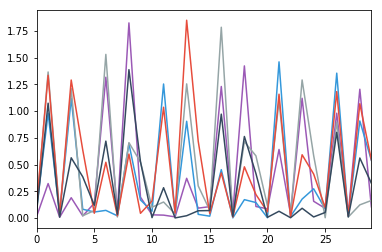

In [134]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[normal_test_example_index]["X_time_abs_reconstruction_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
  sns.tsplot(arr, color = flatui[i%len(flatui)] )

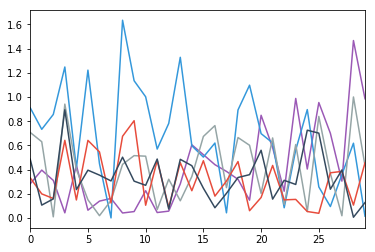

In [135]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[normal_test_example_index]["X_features_abs_reconstruction_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
  sns.tsplot(arr, color = flatui[i%len(flatui)] )

### Anomalous Example

In [136]:
anomalous_test_example_index = np.argmax(arr_test_labels == '1')

In [137]:
predictions_list[anomalous_test_example_index]

{'X_features_abs_reconstruction_error': array([[1.97199777e-01, 2.32093214e-02, 4.35998384e-01, 1.44155849e-01,
         1.61925854e-01],
        [2.73955266e-02, 4.33085042e-02, 9.60722881e-01, 5.06584810e-02,
         4.16041617e-01],
        [1.92091025e+00, 1.82231650e+00, 1.04122560e+00, 5.55680164e+00,
         1.93006474e+00],
        [3.76187225e-01, 2.85247105e-01, 6.39028847e-01, 1.27954713e+00,
         4.29885050e-01],
        [2.85246884e+00, 3.12347935e+00, 1.26793428e+00, 7.12850868e+00,
         2.82011629e+00],
        [3.98231275e-01, 8.63814993e-02, 2.27728747e+00, 1.41860648e+00,
         1.67741763e+00],
        [3.33621902e+00, 2.95937463e+00, 7.53638925e-01, 5.61058834e+00,
         1.44159416e+00],
        [7.05411015e-01, 3.27157821e-01, 2.72746003e+00, 2.53601599e+00,
         1.39335202e+00],
        [1.86212851e+00, 1.58270425e+00, 1.83255083e+00, 8.82684159e-01,
         2.14677123e-01],
        [9.99101342e-01, 1.92495853e-01, 1.50388249e-01, 4.37546475e+0

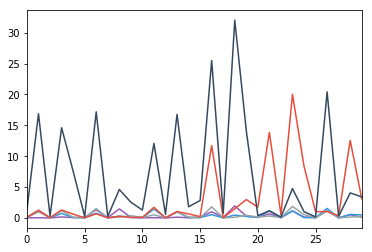

In [138]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[anomalous_test_example_index]["X_time_abs_reconstruction_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
  sns.tsplot(arr, color = flatui[i%len(flatui)] )

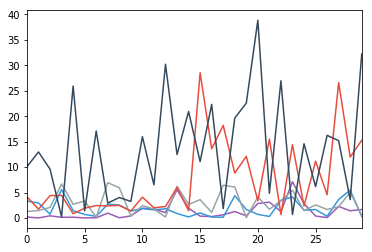

In [139]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[anomalous_test_example_index]["X_features_abs_reconstruction_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
  sns.tsplot(arr, color = flatui[i%len(flatui)] )